# 📊 Amazon India Data Analysis (2015–2025)
This notebook contains 20 Exploratory Data Analysis (EDA) visualizations and analyses.
Each question can be run independently for insights.


In [6]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set paths
DATA_PATH = r'C:\\Users\\desik\\Desktop\\cleaned output\\amazon_india_combined_2015_2025.csv'

# Load dataset
df = pd.read_csv(DATA_PATH)
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df = df.dropna(subset=['order_date'])
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_month_name'] = df['order_date'].dt.strftime('%b')
df['order_ym'] = df['order_date'].dt.to_period('M').astype(str)

def format_inr(x, pos):
    if x >= 1e7:
        return f'₹{x/1e7:.1f}Cr'
    elif x >= 1e5:
        return f'₹{x/1e5:.1f}L'
    else:
        return f'₹{x:,.0f}'
currency_formatter = FuncFormatter(format_inr)


## 🧮 Question 1: Yearly Revenue Trend Analysis (2015–2025)

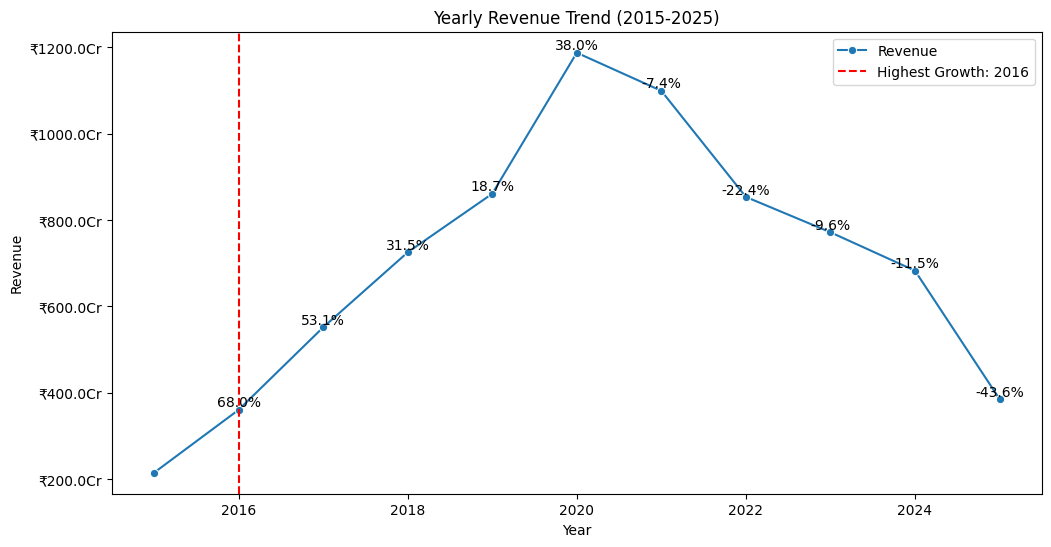

In [3]:
# Calculate yearly revenue
df['revenue'] = df['quantity'] * df['discounted_price_inr']
yearly_revenue = df.groupby('order_year')['revenue'].sum()

# Calculate yearly growth %
revenue_growth = yearly_revenue.pct_change() * 100

# Plot revenue trend
plt.figure(figsize=(12,6))
sns.lineplot(x=yearly_revenue.index, y=yearly_revenue.values, marker='o', label='Revenue')
plt.title("Yearly Revenue Trend (2015-2025)")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.gca().yaxis.set_major_formatter(currency_formatter)

# Annotate percentage growth
for i, val in enumerate(revenue_growth):
    if i > 0:
        plt.text(yearly_revenue.index[i], yearly_revenue.values[i], f'{val:.1f}%', ha='center', va='bottom')

# Highlight key growth periods (example: highest growth year)
max_growth_year = revenue_growth.idxmax()
plt.axvline(x=max_growth_year, color='red', linestyle='--', label=f'Highest Growth: {max_growth_year}')
plt.legend()
plt.show()


## 📅 Question 2: Seasonal Sales Analysis (Monthly Heatmaps)

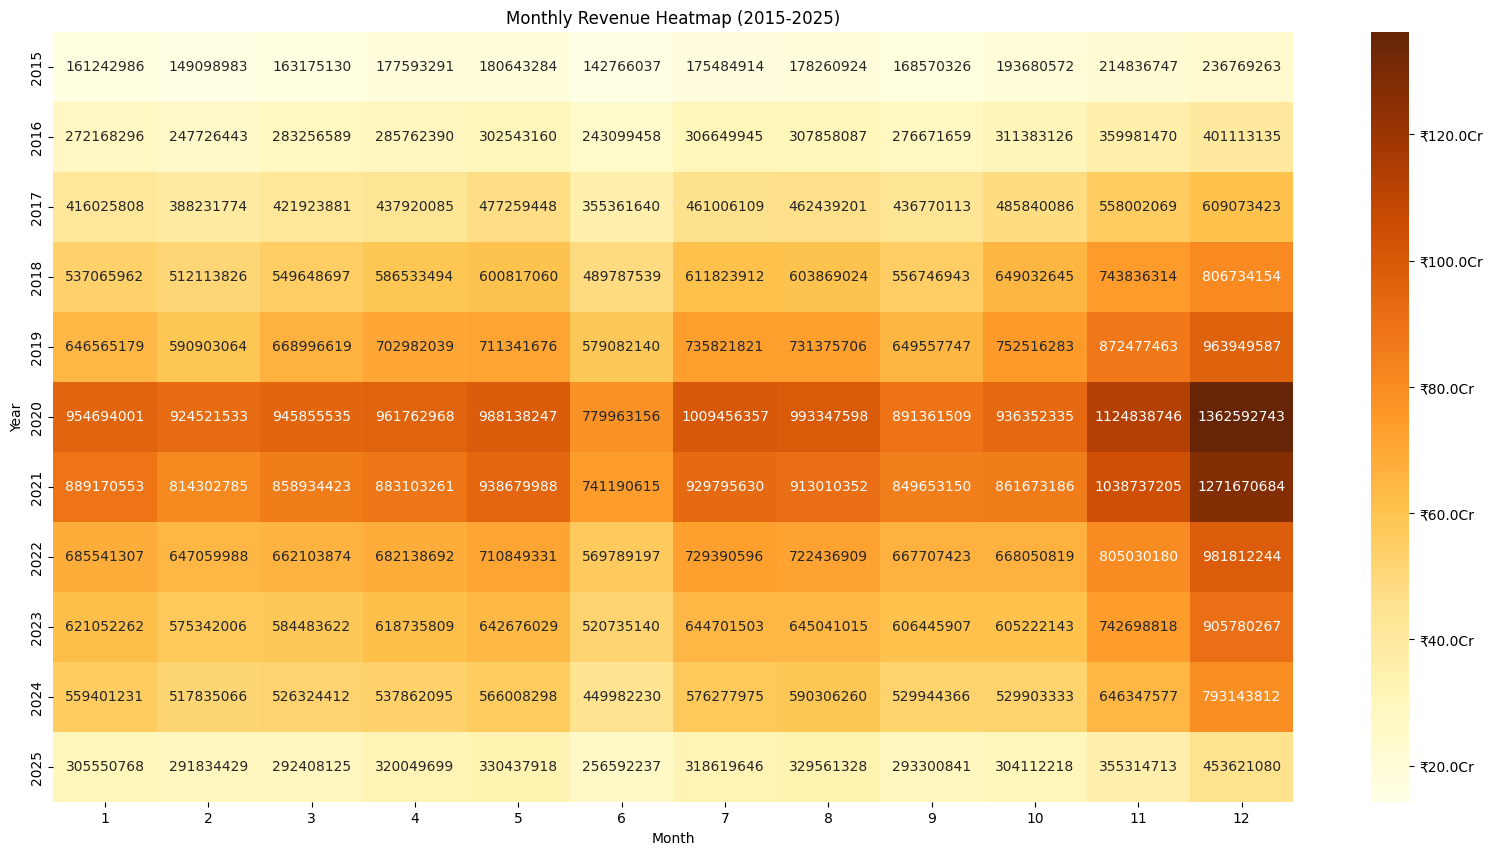

Peak selling months:
 order_month_name
Dec    8.786260e+09
Nov    7.462101e+09
Jul    6.499028e+09
Aug    6.477506e+09
May    6.449394e+09
Oct    6.297767e+09
Apr    6.194444e+09
Jan    6.048478e+09
Mar    5.957111e+09
Sep    5.926730e+09
Feb    5.658970e+09
Jun    5.128349e+09
Name: revenue, dtype: float64


In [4]:
# Pivot table: Revenue by Year vs Month
seasonal_pivot = df.pivot_table(values='revenue', index='order_year', columns='order_month', aggfunc='sum')

# Plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(seasonal_pivot, annot=True, fmt='.0f', cmap='YlOrBr', cbar_kws={'format':currency_formatter})
plt.title("Monthly Revenue Heatmap (2015-2025)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# Identify peak months
peak_months = df.groupby('order_month_name')['revenue'].sum().sort_values(ascending=False)
print("Peak selling months:\n", peak_months)


## 👥 Question 3: Customer Segmentation Analysis using RFM

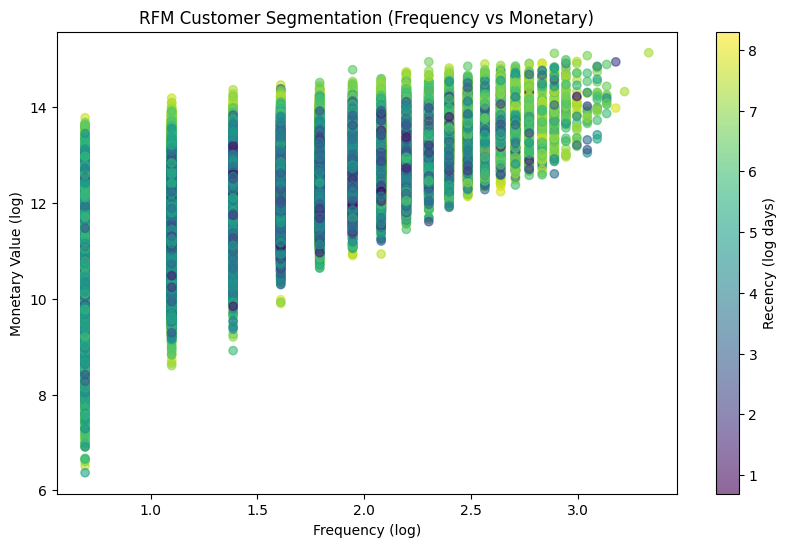

RFM_Score
244    622626.021128
344    597382.436109
144    585810.851758
444    566811.008618
234    465549.696817
334    439095.688240
134    438233.482659
434    418414.582478
224    408785.156477
314    392297.346571
Name: Monetary, dtype: float64

In [5]:
# Today's reference date for Recency calculation
import datetime
snapshot_date = df['order_date'].max() + pd.Timedelta(days=1)

# RFM Metrics
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'transaction_id': 'count',                               # Frequency
    'revenue': 'sum'                                        # Monetary
}).reset_index()

rfm.rename(columns={
    'order_date': 'Recency',
    'transaction_id': 'Frequency',
    'revenue': 'Monetary'
}, inplace=True)

# Optional: Log transform for scatter visualization
rfm_log = rfm.copy()
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])

# Scatter plot: Frequency vs Monetary, color by Recency
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    rfm_log['Frequency'], 
    rfm_log['Monetary'], 
    c=rfm_log['Recency'], 
    cmap='viridis', 
    alpha=0.6
)
plt.colorbar(scatter, label='Recency (log days)')
plt.title("RFM Customer Segmentation (Frequency vs Monetary)")
plt.xlabel("Frequency (log)")
plt.ylabel("Monetary Value (log)")
plt.show()

# Recency: lower is better, so inverse rank
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4,3,2,1], duplicates='drop')

# Frequency & Monetary: higher is better, use rank percentile
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1,2,3,4], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=4, labels=[1,2,3,4], duplicates='drop')

# Combine RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Show top segments
rfm.groupby('RFM_Score')['Monetary'].mean().sort_values(ascending=False).head(10)


## 💰Question 4: Payment Methods Evolution (2015–2025)

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2111872738.py:40: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


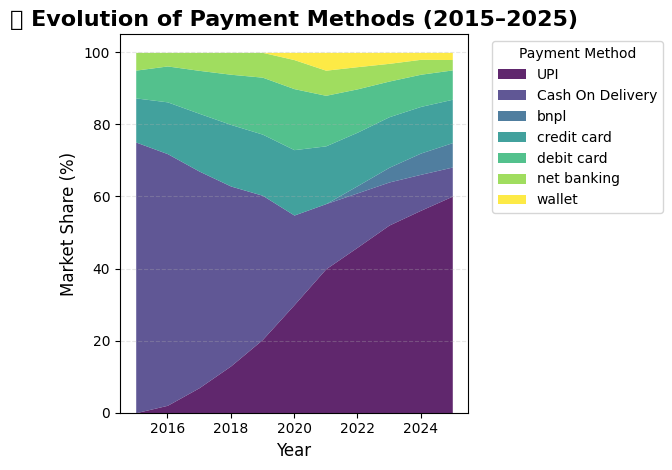

📈 Payment Method Share Change (2015 → 2025):


payment_method  market_share_latest  market_share_earliest  Change_%
1               UPI                60.10                   0.00     60.10
2              bnpl                 6.77                   0.00      6.77
6            wallet                 1.99                   0.00      1.99
4        debit card                 8.14                   7.71      0.43
3       credit card                12.04                  12.24     -0.20
5       net banking                 2.89                   4.93     -2.04
0  Cash On Delivery                 8.08                  75.12    -67.03

In [6]:
# ============================
# 🧾 PAYMENT METHOD EVOLUTION
# ============================

# Ensure required columns exist
if 'payment_method' not in df.columns or 'final_amount_inr' not in df.columns:
    print("⚠️ Missing 'payment_method' or 'final_amount_inr' in dataset.")
else:
    # Aggregate revenue by year and payment method
    payment_trends = (
        df.groupby(['order_year', 'payment_method'])['final_amount_inr']
        .sum()
        .reset_index()
    )

    # Calculate market share (%) by year
    total_by_year = payment_trends.groupby('order_year')['final_amount_inr'].transform('sum')
    payment_trends['market_share'] = (payment_trends['final_amount_inr'] / total_by_year) * 100

    # Pivot for stacked area plot
    payment_pivot = payment_trends.pivot(index='order_year', columns='payment_method', values='market_share').fillna(0)

    # Sort payment methods for better stacking order (UPI at top)
    payment_pivot = payment_pivot[[c for c in payment_pivot.columns if 'UPI' in c] +
                                  [c for c in payment_pivot.columns if 'Credit' in c] +
                                  [c for c in payment_pivot.columns if 'Debit' in c] +
                                  [c for c in payment_pivot.columns if 'Wallet' in c] +
                                  [c for c in payment_pivot.columns if 'COD' in c] +
                                  [c for c in payment_pivot.columns if c not in ['UPI', 'Credit Card', 'Debit Card', 'Wallet', 'COD']]]

    # --- Plot Stacked Area Chart ---
    plt.figure(figsize=(12, 6))
    payment_pivot.plot(kind='area', stacked=True, colormap='viridis', alpha=0.85, linewidth=0)

    plt.title("💳 Evolution of Payment Methods (2015–2025)", fontsize=16, weight='bold')
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Market Share (%)", fontsize=12)
    plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Trend Insights (Optional Printout) ---
    latest_year = payment_trends['order_year'].max()
    earliest_year = payment_trends['order_year'].min()
    print("📈 Payment Method Share Change ({} → {}):".format(earliest_year, latest_year))
    change = (
        payment_trends[payment_trends['order_year'] == latest_year][['payment_method', 'market_share']]
        .merge(payment_trends[payment_trends['order_year'] == earliest_year][['payment_method', 'market_share']],
               on='payment_method', suffixes=('_latest', '_earliest'), how='outer')
        .fillna(0)
    )
    change['Change_%'] = change['market_share_latest'] - change['market_share_earliest']
    display(change.sort_values('Change_%', ascending=False).round(2))

plt.show()



## 🛍️ Question 5: Category-Wise Performance Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\392350884.py:24: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


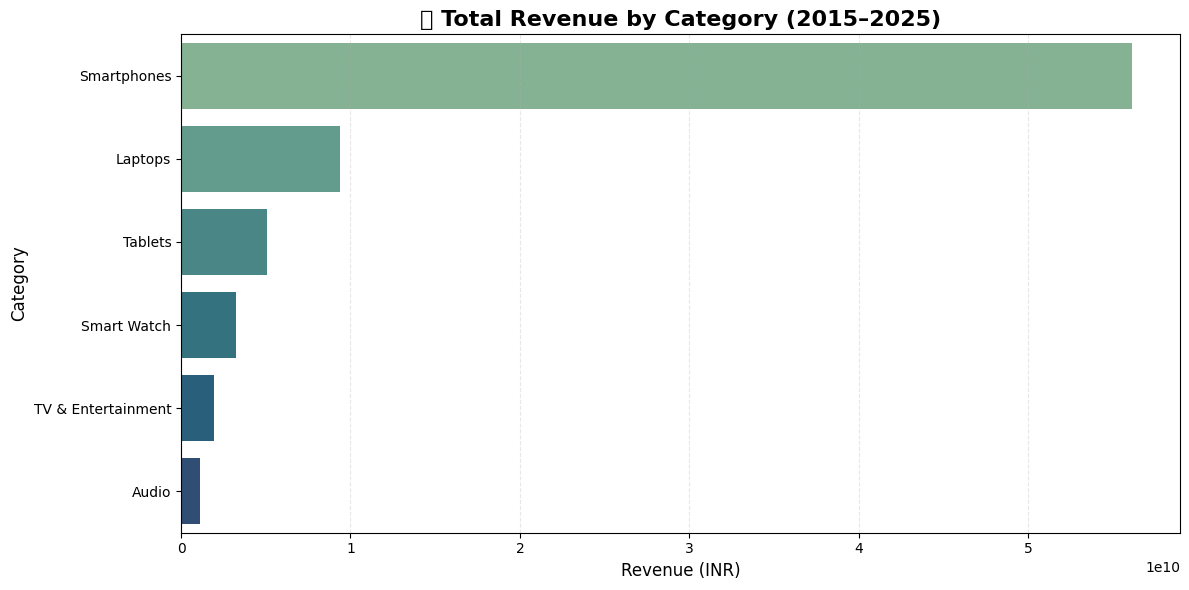

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\392350884.py:35: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


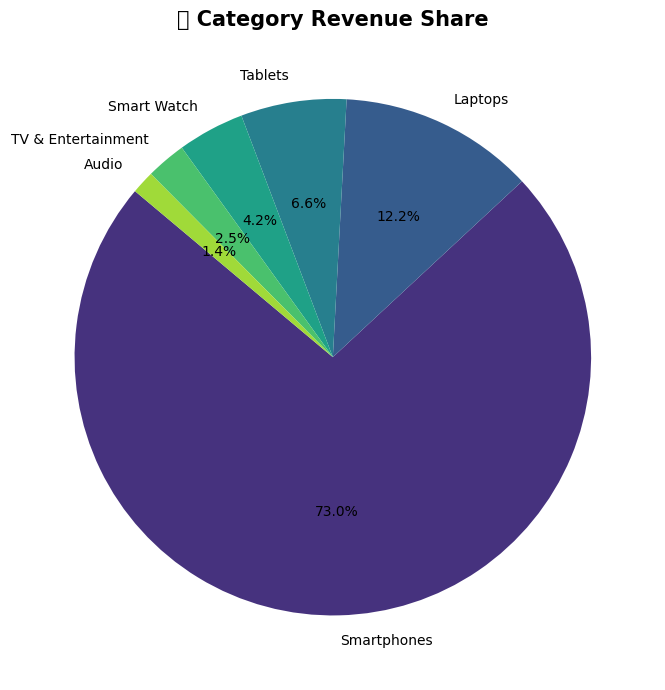

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\392350884.py:55: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


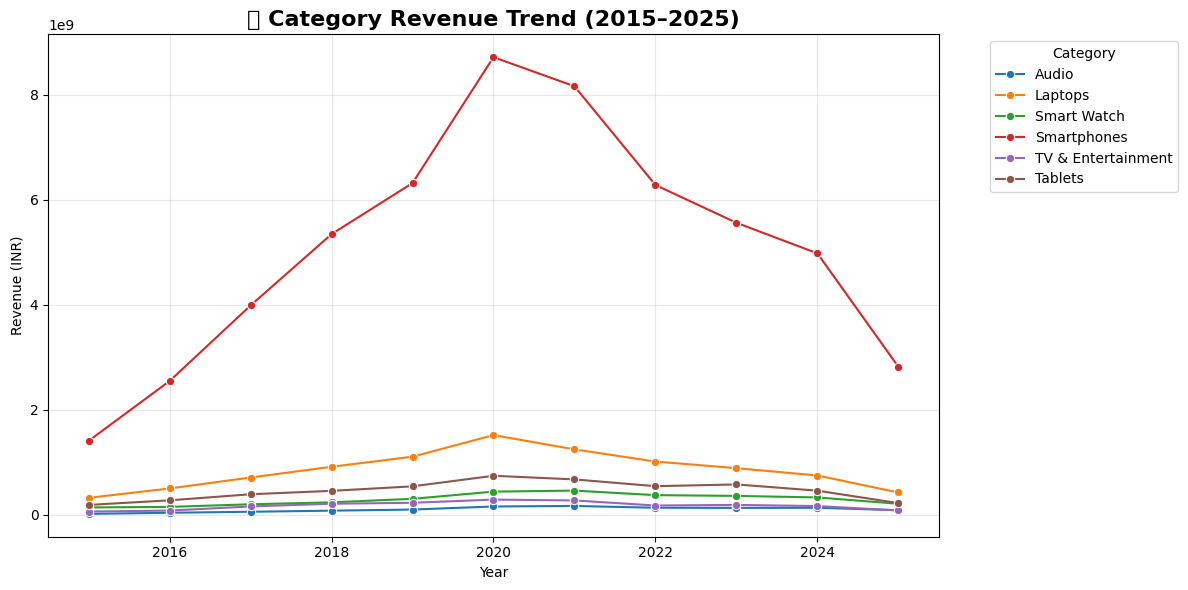

📊 Category Growth Summary (2015–2025):


subcategory           min           max  Growth_%
0               Audio  1.780509e+07  1.689925e+08    849.12
3         Smartphones  1.409377e+09  8.719442e+09    518.67
1             Laptops  3.238882e+08  1.518632e+09    368.88
4  TV & Entertainment  6.198430e+07  2.900257e+08    367.90
5             Tablets  1.885595e+08  7.439726e+08    294.56
2         Smart Watch  1.405078e+08  4.613164e+08    228.32

In [22]:
# ============================
# 🛍️ CATEGORY-WISE PERFORMANCE
# ============================

# Ensure necessary columns exist
required_cols = ['order_year', 'category', 'final_amount_inr']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Total Revenue by Category ---
    cat_revenue = (
        df.groupby('subcategory')['final_amount_inr']
        .sum()
        .reset_index()
        .sort_values(by='final_amount_inr', ascending=False)
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(data=cat_revenue, x='final_amount_inr', y='subcategory', palette='crest')
    plt.title("💰 Total Revenue by Category (2015–2025)", fontsize=16, weight='bold')
    plt.xlabel("Revenue (INR)", fontsize=12)
    plt.ylabel("Category", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Category Revenue Share (Pie Chart) ---
    plt.figure(figsize=(7, 7))
    plt.pie(cat_revenue['final_amount_inr'],
            labels=cat_revenue['subcategory'],
            autopct='%1.1f%%',
            startangle=140,
            colors=sns.color_palette('viridis', len(cat_revenue)))
    plt.title("🧩 Category Revenue Share", fontsize=15, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Yearly Growth by Category ---
    yearly_cat = (
        df.groupby(['order_year', 'subcategory'])['final_amount_inr']
        .sum()
        .reset_index()
    )

    # Calculate YoY Growth %
    yearly_cat['YoY_Growth'] = yearly_cat.groupby('subcategory')['final_amount_inr'].pct_change() * 100

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_cat, x='order_year', y='final_amount_inr', hue='subcategory', marker='o', palette='tab10')
    plt.title("📈 Category Revenue Trend (2015–2025)", fontsize=16, weight='bold')
    plt.xlabel("Year")
    plt.ylabel("Revenue (INR)")
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Category Growth Summary ---
    cat_growth_summary = (
        yearly_cat.groupby('subcategory')['final_amount_inr']
        .agg(['min', 'max'])
        .reset_index()
    )
    cat_growth_summary['Growth_%'] = ((cat_growth_summary['max'] - cat_growth_summary['min']) / cat_growth_summary['min']) * 100
    cat_growth_summary = cat_growth_summary.sort_values(by='Growth_%', ascending=False)

    print("📊 Category Growth Summary (2015–2025):")
    display(cat_growth_summary.round(2))



## 💎 Question 6: Prime Membership Impact on Customer Behavior

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\1275597302.py:24: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


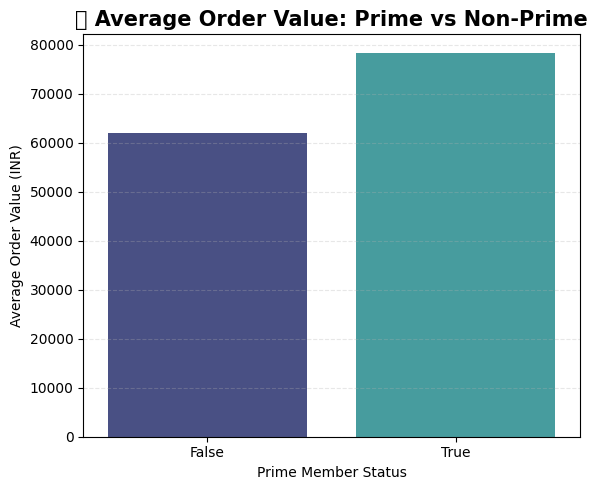

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\1275597302.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


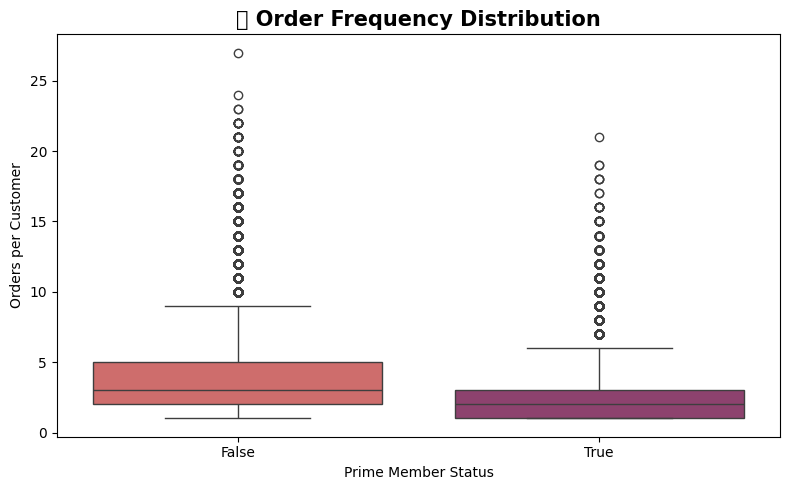

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\1275597302.py:57: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


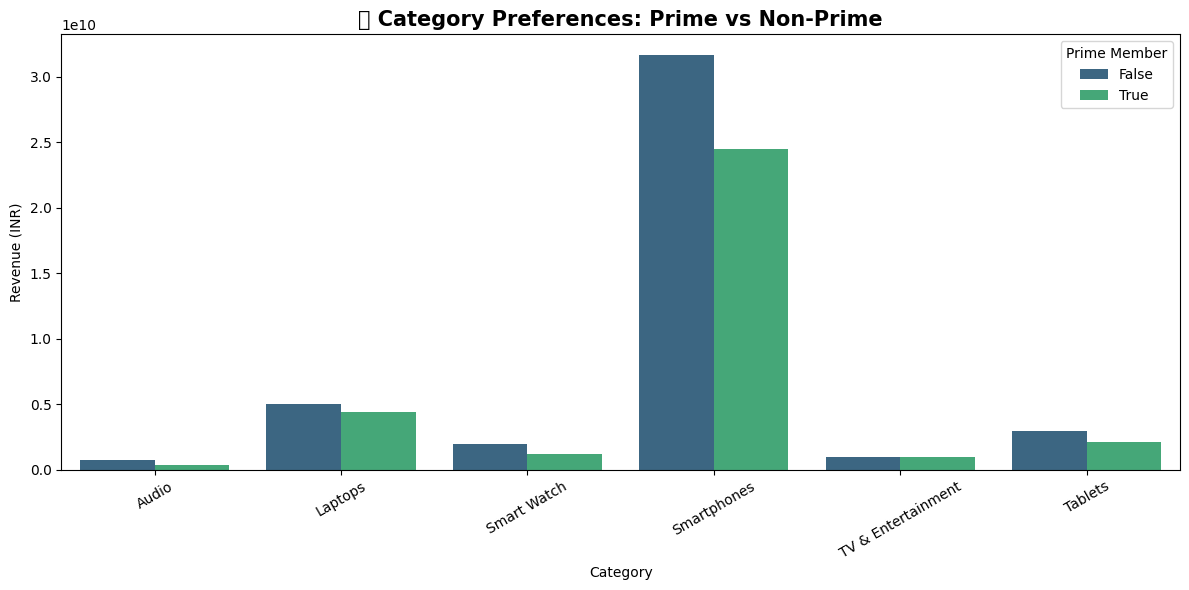

📊 Prime vs Non-Prime Summary:


is_prime_member  avg_order_value  total_orders  total_revenue
0            False         62034.45        698456   4.332834e+10
1             True         78203.09        429111   3.355780e+10

In [23]:
# ================================
# 💎 PRIME MEMBERSHIP ANALYSIS
# ================================

# Ensure required columns exist
required_cols = ['is_prime_member', 'customer_id', 'final_amount_inr', 'subcategory']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Average Order Value (AOV) Comparison ---
    prime_aov = (
        df.groupby('is_prime_member',)['final_amount_inr']
        .mean()
        .reset_index()
        .rename(columns={'final_amount_inr': 'avg_order_value'})
    )

    plt.figure(figsize=(6,5))
    sns.barplot(data=prime_aov, x='is_prime_member', y='avg_order_value', palette='mako')
    plt.title("💸 Average Order Value: Prime vs Non-Prime", fontsize=15, weight='bold')
    plt.xlabel("Prime Member Status")
    plt.ylabel("Average Order Value (INR)")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Order Frequency per Customer ---
    order_freq = (
        df.groupby(['is_prime_member', 'customer_id'])['transaction_id']
        .count()
        .reset_index()
        .rename(columns={'transaction_id': 'order_count'})
    )

    plt.figure(figsize=(8,5))
    sns.boxplot(data=order_freq, x='is_prime_member', y='order_count', palette='flare')
    plt.title("📦 Order Frequency Distribution", fontsize=15, weight='bold')
    plt.xlabel("Prime Member Status")
    plt.ylabel("Orders per Customer")
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Category Preference Analysis ---
    cat_pref = (
        df.groupby(['is_prime_member', 'subcategory'])['final_amount_inr']
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(12,6))
    sns.barplot(data=cat_pref, x='subcategory', y='final_amount_inr', hue='is_prime_member', palette='viridis')
    plt.title("🛍️ Category Preferences: Prime vs Non-Prime", fontsize=15, weight='bold')
    plt.xlabel("Category")
    plt.ylabel("Revenue (INR)")
    plt.xticks(rotation=30)
    plt.legend(title="Prime Member", loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Summary Table ---
    summary = (
        df.groupby('is_prime_member')
        .agg(
            avg_order_value=('final_amount_inr', 'mean'),
            total_orders=('transaction_id', 'count'),
            total_revenue=('final_amount_inr', 'sum')
        )
        .reset_index()
    )

    print("📊 Prime vs Non-Prime Summary:")
    display(summary.round(2))


## 🌍 Question 7: Geographic Analysis of Sales Performance

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2593926396.py:25: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


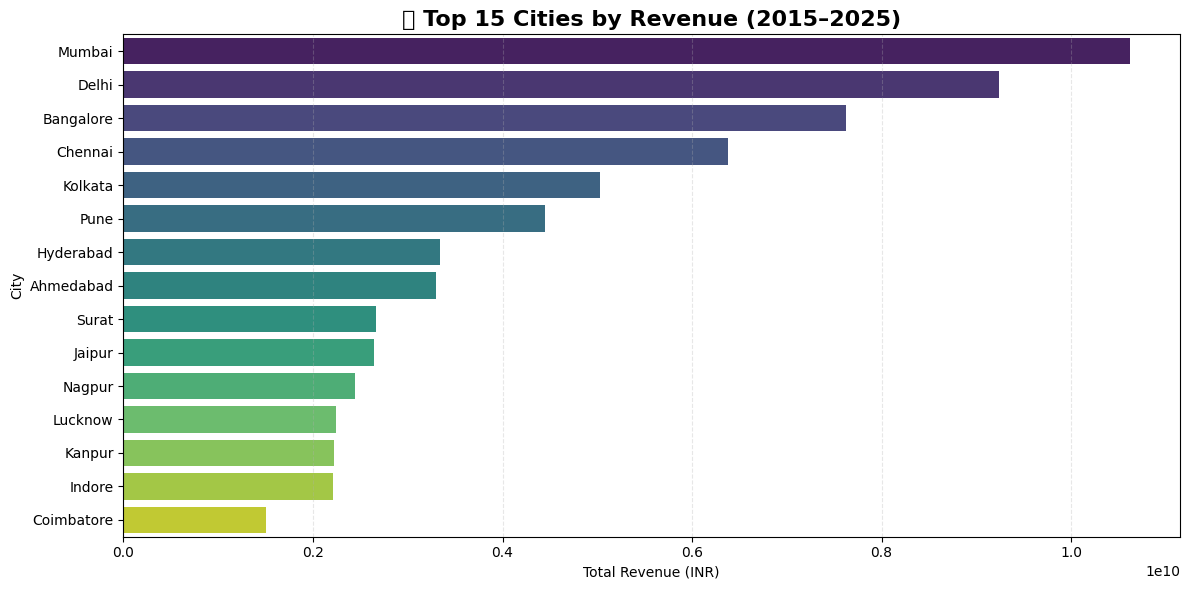

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2593926396.py:42: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


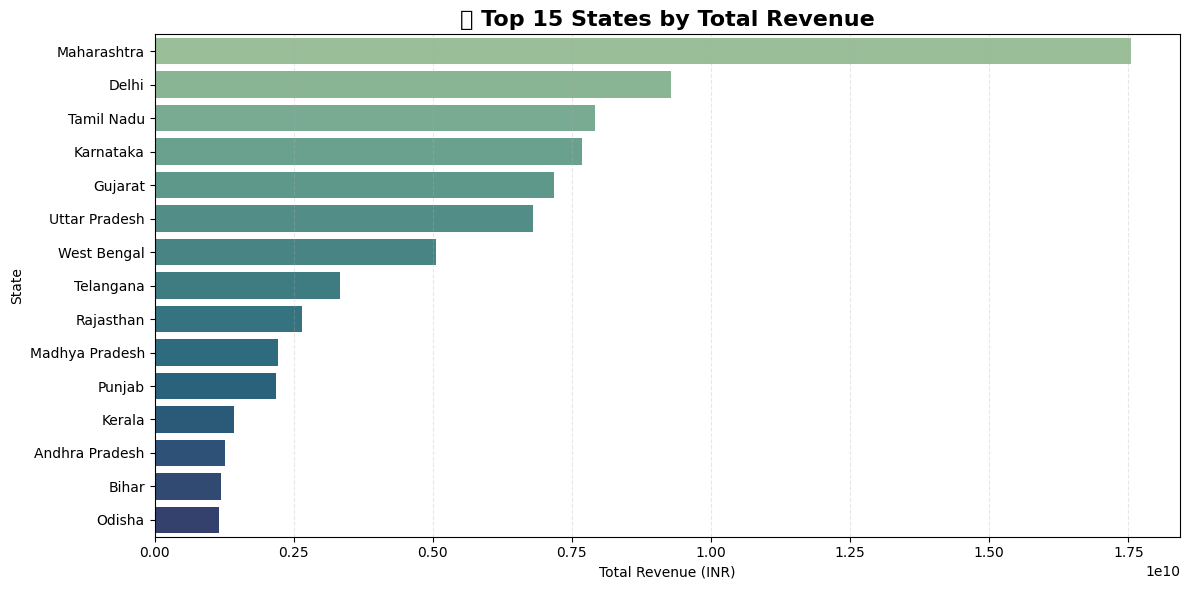

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2593926396.py:62: UserWarning: Glyph 127750 (\N{CITYSCAPE AT DUSK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127750 (\N{CITYSCAPE AT DUSK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


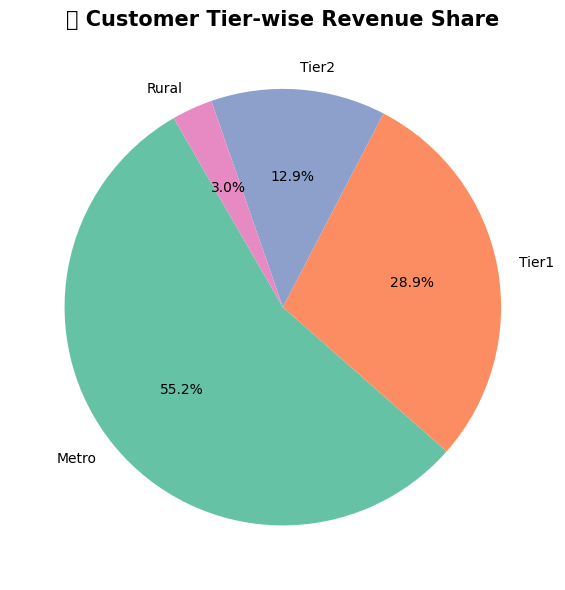

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2593926396.py:78: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


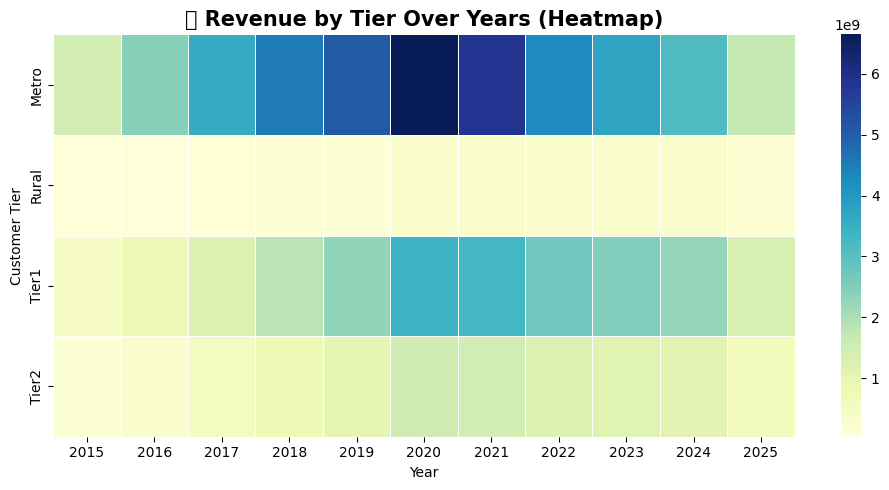

📋 Tier-wise Summary:


customer_tier  total_revenue  avg_order_value  total_orders
0         Metro   4.242405e+10         75246.10        563804
1         Rural   2.323338e+09         46476.05         49990
2         Tier1   2.218938e+10         65528.28        338623
3         Tier2   9.949366e+09         56804.83        175150

In [10]:
# ====================================
# 🌍 GEOGRAPHIC SALES PERFORMANCE
# ====================================

# Ensure required columns exist
required_cols = ['customer_city', 'customer_state', 'customer_tier', 'order_year', 'final_amount_inr']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Top 15 Cities by Revenue ---
    top_cities = (
        df.groupby('customer_city')['final_amount_inr']
        .sum()
        .reset_index()
        .sort_values(by='final_amount_inr', ascending=False)
        .head(15)
    )

    plt.figure(figsize=(12,6))
    sns.barplot(data=top_cities, x='final_amount_inr', y='customer_city', palette='viridis')
    plt.title("🏙️ Top 15 Cities by Revenue (2015–2025)", fontsize=16, weight='bold')
    plt.xlabel("Total Revenue (INR)")
    plt.ylabel("City")
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ State-Wise Total Revenue ---
    state_revenue = (
        df.groupby('customer_state')['final_amount_inr']
        .sum()
        .reset_index()
        .sort_values(by='final_amount_inr', ascending=False)
    )

    plt.figure(figsize=(12,6))
    sns.barplot(data=state_revenue.head(15), x='final_amount_inr', y='customer_state', palette='crest')
    plt.title("🗺️ Top 15 States by Total Revenue", fontsize=16, weight='bold')
    plt.xlabel("Total Revenue (INR)")
    plt.ylabel("State")
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Tier-Wise Revenue Share ---
    tier_revenue = (
        df.groupby('customer_tier')['final_amount_inr']
        .sum()
        .reset_index()
        .sort_values(by='final_amount_inr', ascending=False)
    )

    plt.figure(figsize=(6,6))
    plt.pie(
        tier_revenue['final_amount_inr'],
        labels=tier_revenue['customer_tier'],
        autopct='%1.1f%%',
        startangle=120,
        colors=sns.color_palette('Set2', len(tier_revenue))
    )
    plt.title("🌆 Customer Tier-wise Revenue Share", fontsize=15, weight='bold')
    plt.tight_layout()
    plt.show()

# --- 4️⃣ Revenue by Tier over Time (Heatmap) ---
tier_year = (
    df.groupby(['order_year', 'customer_tier'])['final_amount_inr']
    .sum()
    .reset_index()
    .pivot(index='customer_tier', columns='order_year', values='final_amount_inr')
)

plt.figure(figsize=(10,5))
sns.heatmap(tier_year, cmap='YlGnBu', fmt='.0f', linewidths=0.5)
plt.title("📊 Revenue by Tier Over Years (Heatmap)", fontsize=15, weight='bold')
plt.xlabel("Year")
plt.ylabel("Customer Tier")
plt.tight_layout()
plt.show()


# --- 5️⃣ Summary Table ---
geo_summary = (
    df.groupby('customer_tier')
    .agg(
        total_revenue=('final_amount_inr', 'sum'),
        avg_order_value=('final_amount_inr', 'mean'),
        total_orders=('transaction_id', 'count')
    )
    .reset_index()
)

print("📋 Tier-wise Summary:")
display(geo_summary.round(2))

## 🎆 Question 8: Festival Sales Impact Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2975774523.py:25: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


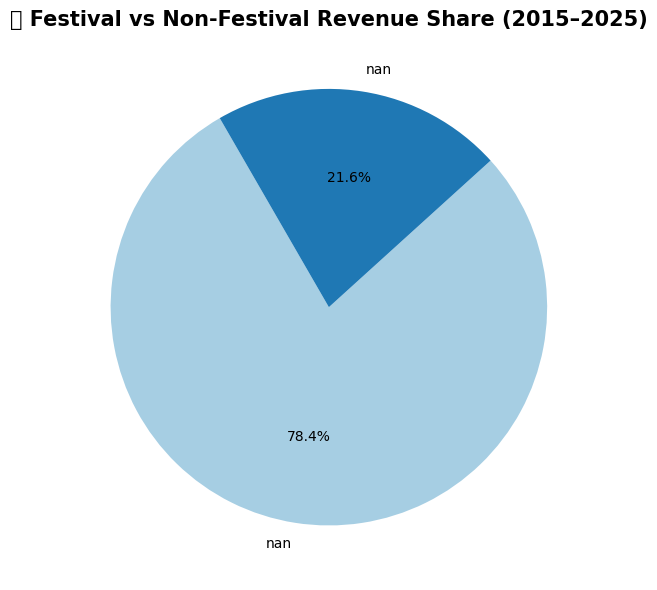

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2975774523.py:44: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


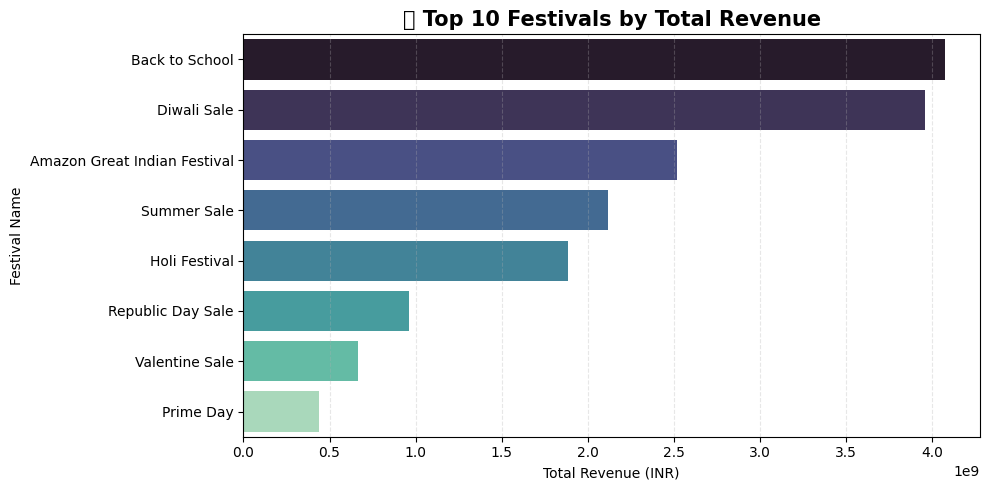

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2975774523.py:68: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


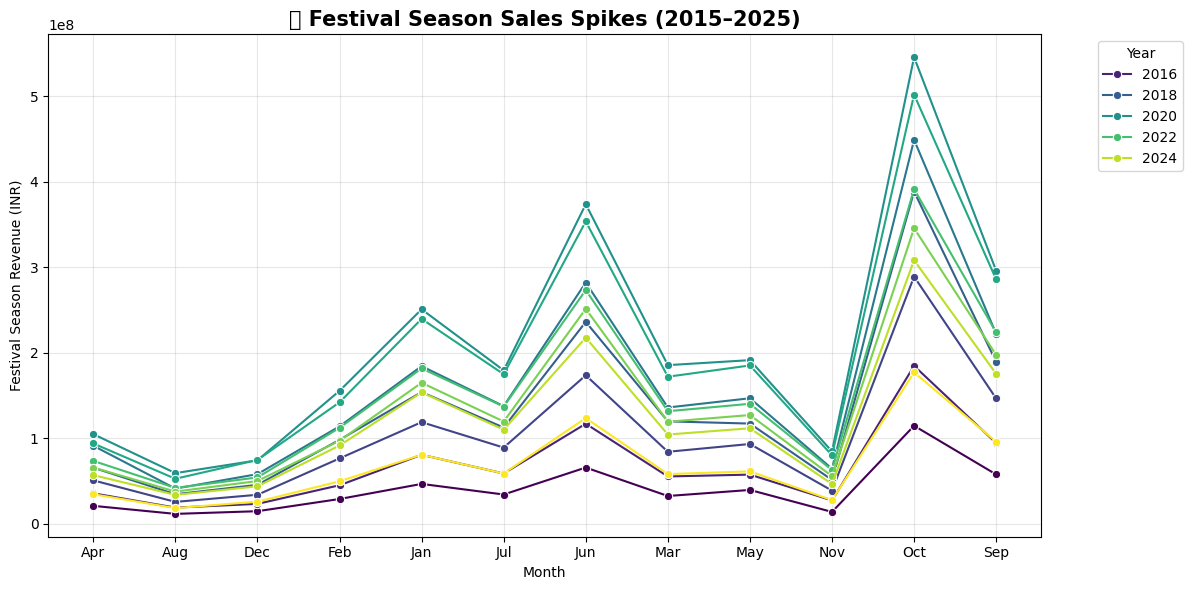

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\2975774523.py:86: UserWarning: Glyph 129684 (\N{DIYA LAMP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129684 (\N{DIYA LAMP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


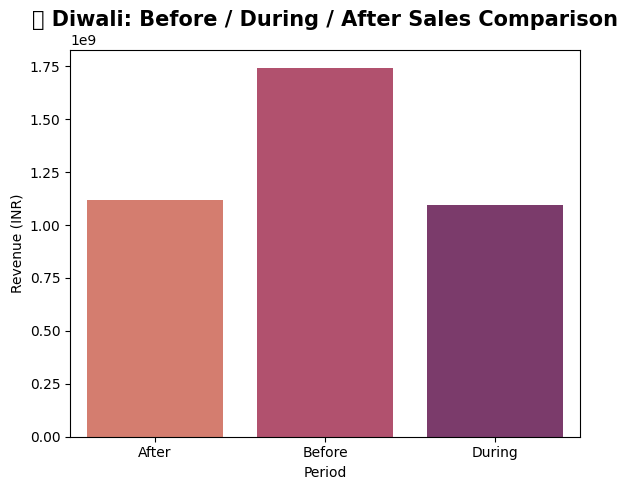

📋 Festival vs Non-Festival Summary:


is_festival_sale  total_revenue  avg_order_value  total_orders
0             False   6.026828e+10         77494.94        777706
1              True   1.661786e+10         47498.46        349861

In [11]:
# =====================================
# 🎆 FESTIVAL SALES IMPACT ANALYSIS
# =====================================

# Ensure required columns exist
required_cols = ['order_date', 'order_year', 'festival_name', 'is_festival_sale', 'final_amount_inr']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Festival vs Non-Festival Revenue Share ---
    fest_revenue = (
        df.groupby('is_festival_sale')['final_amount_inr']
        .sum()
        .reset_index()
    )
    fest_revenue['label'] = fest_revenue['is_festival_sale'].map({1: 'Festival Sale', 0: 'Non-Festival'})

    plt.figure(figsize=(6,6))
    plt.pie(fest_revenue['final_amount_inr'],
            labels=fest_revenue['label'],
            autopct='%1.1f%%',
            startangle=120,
            colors=sns.color_palette('Paired', len(fest_revenue)))
    plt.title("🎉 Festival vs Non-Festival Revenue Share (2015–2025)", fontsize=15, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Top Festivals by Total Revenue ---
    top_festivals = (
        df[df['is_festival_sale'] == 1]
        .groupby('festival_name')['final_amount_inr']
        .sum()
        .reset_index()
        .sort_values(by='final_amount_inr', ascending=False)
        .head(10)
    )

    plt.figure(figsize=(10,5))
    sns.barplot(data=top_festivals, x='final_amount_inr', y='festival_name', palette='mako')
    plt.title("🏆 Top 10 Festivals by Total Revenue", fontsize=15, weight='bold')
    plt.xlabel("Total Revenue (INR)")
    plt.ylabel("Festival Name")
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Festival Season Timeline (Yearly Comparison) ---
    monthly_fest = (
        df.groupby(['order_year', 'order_month_name', 'is_festival_sale'])['final_amount_inr']
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(12,6))
    sns.lineplot(
        data=monthly_fest[monthly_fest['is_festival_sale'] == 1],
        x='order_month_name',
        y='final_amount_inr',
        hue='order_year',
        marker='o',
        palette='viridis'
    )
    plt.title("📈 Festival Season Sales Spikes (2015–2025)", fontsize=15, weight='bold')
    plt.xlabel("Month")
    plt.ylabel("Festival Season Revenue (INR)")
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Before vs During vs After Analysis (Example: Diwali) ---
    diwali_data = df[df['festival_name'].str.contains('Diwali', case=False, na=False)].copy()
    if not diwali_data.empty:
        diwali_data['period'] = np.where(
            diwali_data['order_date'].dt.day.between(20, 25), 'During',
            np.where(diwali_data['order_date'].dt.day < 20, 'Before', 'After')
        )

        period_revenue = diwali_data.groupby('period')['final_amount_inr'].sum().reset_index()

        plt.figure(figsize=(6,5))
        sns.barplot(data=period_revenue, x='period', y='final_amount_inr', palette='flare')
        plt.title("🪔 Diwali: Before / During / After Sales Comparison", fontsize=15, weight='bold')
        plt.xlabel("Period")
        plt.ylabel("Revenue (INR)")
        plt.tight_layout()
        plt.show()

    # --- 5️⃣ Festival Impact Summary ---
    fest_summary = (
        df.groupby('is_festival_sale')
        .agg(
            total_revenue=('final_amount_inr', 'sum'),
            avg_order_value=('final_amount_inr', 'mean'),
            total_orders=('transaction_id', 'count')
        )
        .reset_index()
    )

    print("📋 Festival vs Non-Festival Summary:")
    display(fest_summary.round(2))


##  👥 Question 9: Customer Age Group Behavior & Preferences

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\309925873.py:29: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


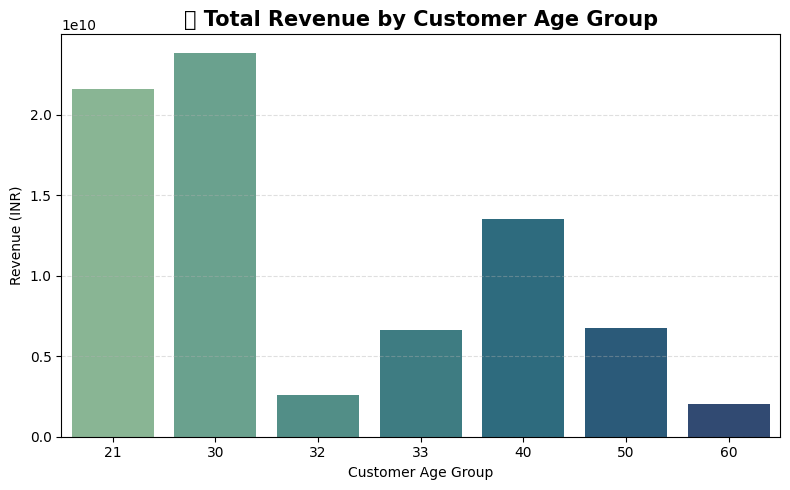

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\309925873.py:39: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


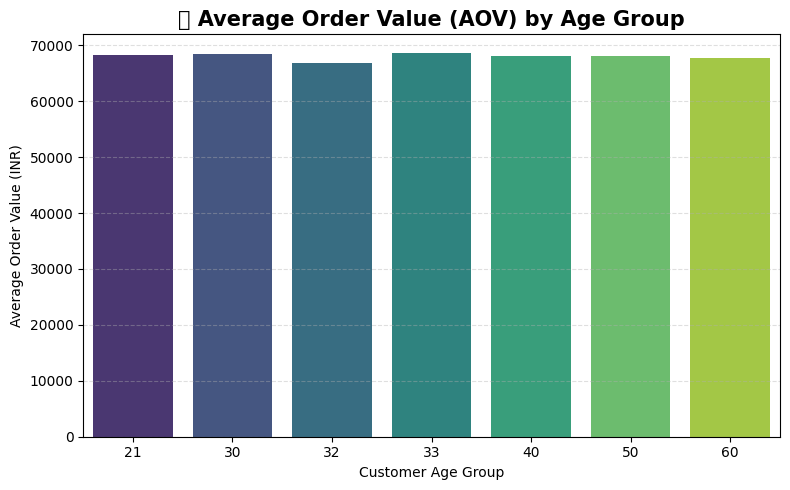

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\309925873.py:65: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


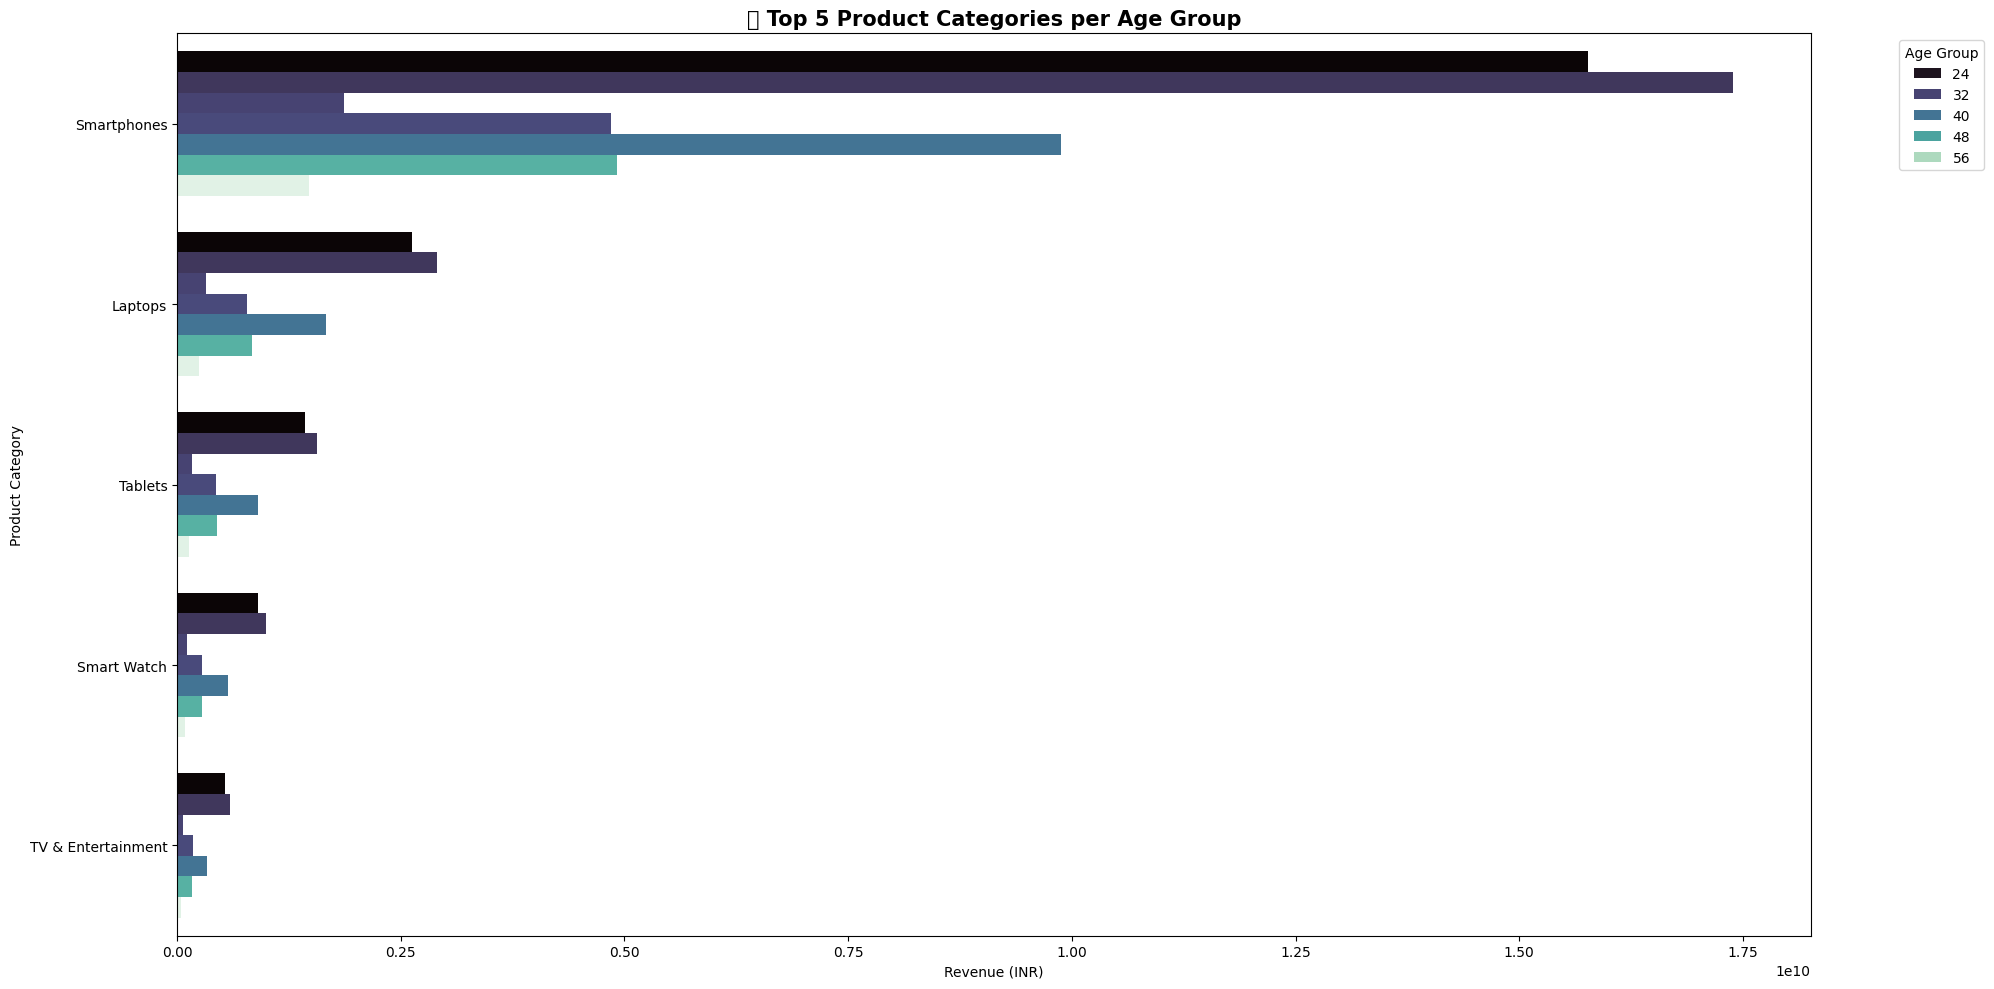

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\309925873.py:89: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


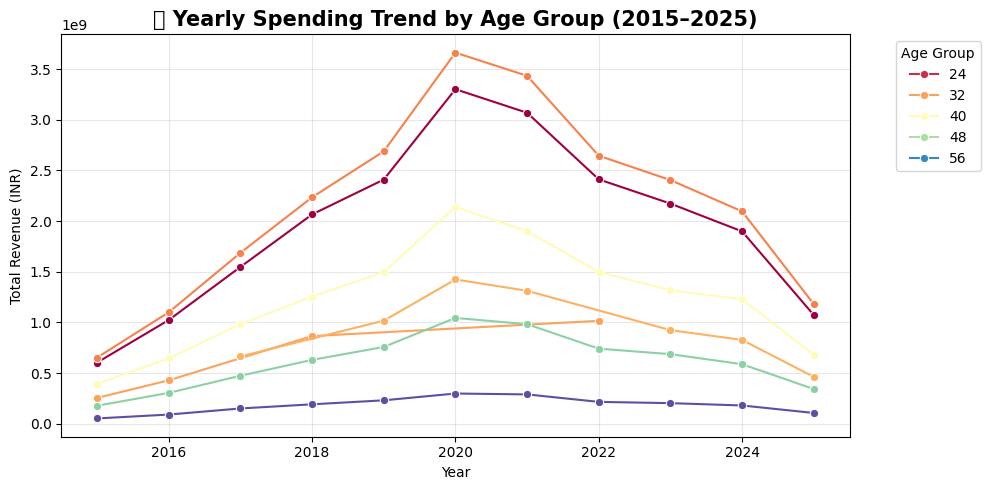

📋 Customer Age Group Summary:


customer_age_group  total_revenue  total_orders  avg_order_value
1                  30   2.379187e+10        347883         68390.43
0                  21   2.158355e+10        316408         68214.29
4                  40   1.354643e+10        199096         68039.68
5                  50   6.738665e+09         99009         68061.13
3                  33   6.636555e+09         96851         68523.35
2                  32   2.567906e+09         38462         66764.75
6                  60   2.021173e+09         29858         67692.85

In [25]:
# ========================================
# 👥 CUSTOMER AGE GROUP BEHAVIOR ANALYSIS
# ========================================

# Ensure the columns exist
required_cols = ['customer_age_group', 'final_amount_inr', 'transaction_id', 'subcategory', 'order_year']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Revenue, Orders & AOV by Age Group ---
    age_stats = (
        df.groupby('customer_age_group')
        .agg(
            total_revenue=('final_amount_inr', 'sum'),
            total_orders=('transaction_id', 'count'),
            avg_order_value=('final_amount_inr', 'mean')
        )
        .reset_index()
        .sort_values(by='total_revenue', ascending=False)
    )

    # Plot 1: Revenue by Age Group
    plt.figure(figsize=(8,5))
    sns.barplot(data=age_stats, x='customer_age_group', y='total_revenue', palette='crest')
    plt.title("💰 Total Revenue by Customer Age Group", fontsize=15, weight='bold')
    plt.xlabel("Customer Age Group")
    plt.ylabel("Revenue (INR)")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # Plot 2: Average Order Value (AOV) by Age Group
    plt.figure(figsize=(8,5))
    sns.barplot(data=age_stats, x='customer_age_group', y='avg_order_value', palette='viridis')
    plt.title("🧾 Average Order Value (AOV) by Age Group", fontsize=15, weight='bold')
    plt.xlabel("Customer Age Group")
    plt.ylabel("Average Order Value (INR)")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Top Product Categories per Age Group ---
    top_cats_age = (
        df.groupby(['customer_age_group', 'subcategory'])['final_amount_inr']
        .sum()
        .reset_index()
    )

    # Get top 5 categories per age group
    top_cats_age = top_cats_age.sort_values(['customer_age_group', 'final_amount_inr'], ascending=[True, False])
    top_cats_age = top_cats_age.groupby('customer_age_group').head(5)

    plt.figure(figsize=(20,10))
    sns.barplot(
        data=top_cats_age,
        x='final_amount_inr',
        y='subcategory',
        hue='customer_age_group',
        palette='mako'
    )
    plt.title("🏷️ Top 5 Product Categories per Age Group", fontsize=15, weight='bold')
    plt.xlabel("Revenue (INR)")
    plt.ylabel("Product Category")
    plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Spending Trend by Age Group Over Time ---
    yearly_age_trend = (
        df.groupby(['order_year', 'customer_age_group'])['final_amount_inr']
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(10,5))
    sns.lineplot(
        data=yearly_age_trend,
        x='order_year',
        y='final_amount_inr',
        hue='customer_age_group',
        marker='o',
        palette='Spectral'
    )
    plt.title("📈 Yearly Spending Trend by Age Group (2015–2025)", fontsize=15, weight='bold')
    plt.xlabel("Year")
    plt.ylabel("Total Revenue (INR)")
    plt.grid(alpha=0.3)
    plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Summary Table ---
    print("📋 Customer Age Group Summary:")
    display(age_stats.round(2))


## 💵 Question 10: Price vs Demand Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\3727653958.py:24: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


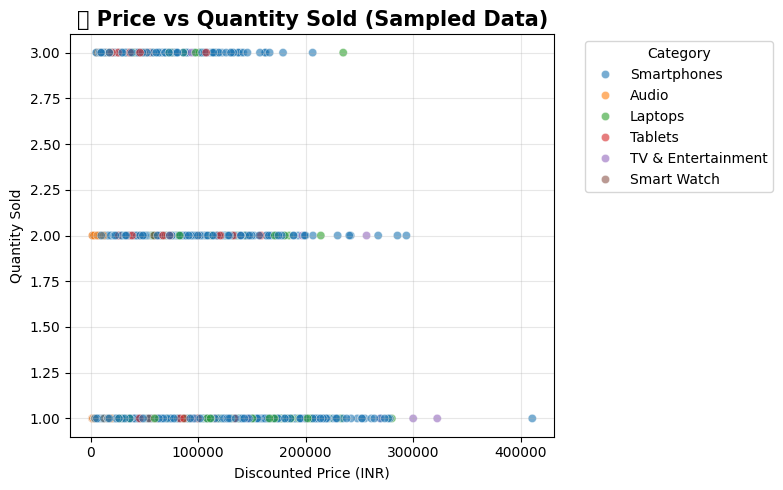

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\3727653958.py:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


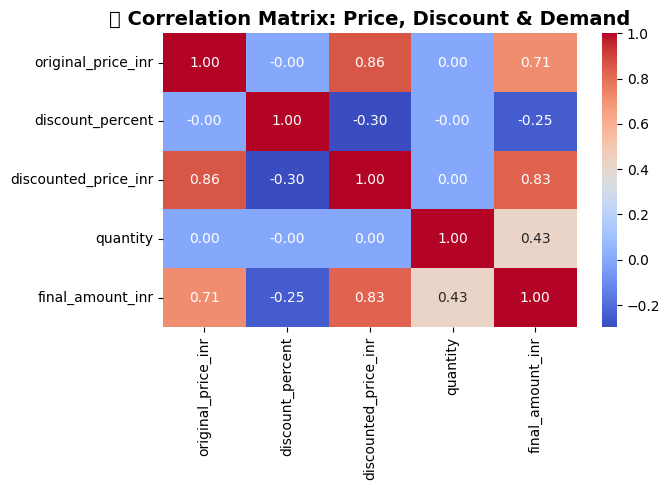

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\3727653958.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


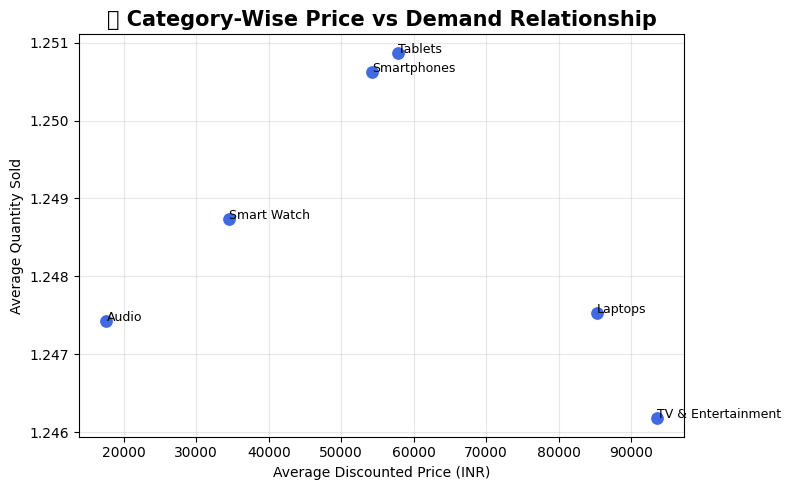

📋 Correlation Insights:
• Price vs Quantity correlation: 0.0
• Discount vs Quantity correlation: -0.001
• Price vs Revenue correlation: 0.832


In [26]:
# =====================================
# 💵 PRICE VS DEMAND ANALYSIS
# =====================================

# Ensure required columns exist
required_cols = ['discounted_price_inr', 'quantity', 'subcategory', 'discount_percent', 'final_amount_inr']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Scatter Plot: Price vs Quantity Sold ---
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        data=df.sample(5000, random_state=42) if len(df) > 5000 else df,
        x='discounted_price_inr',
        y='quantity',
        hue='subcategory',
        alpha=0.6
    )
    plt.title("💸 Price vs Quantity Sold (Sampled Data)", fontsize=15, weight='bold')
    plt.xlabel("Discounted Price (INR)")
    plt.ylabel("Quantity Sold")
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Correlation Matrix for Pricing & Demand ---
    corr_data = df[['original_price_inr', 'discount_percent', 'discounted_price_inr', 'quantity', 'final_amount_inr']].corr()

    plt.figure(figsize=(7,5))
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("🔍 Correlation Matrix: Price, Discount & Demand", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Category-Wise Price vs Quantity (Trend) ---
    cat_price_trend = (
        df.groupby('subcategory')
        .agg(
            avg_price=('discounted_price_inr', 'mean'),
            avg_quantity=('quantity', 'mean')
        )
        .reset_index()
    )

    plt.figure(figsize=(8,5))
    sns.scatterplot(
        data=cat_price_trend,
        x='avg_price',
        y='avg_quantity',
        s=100,
        color='royalblue'
    )
    for i in range(len(cat_price_trend)):
        plt.text(
            cat_price_trend['avg_price'][i],
            cat_price_trend['avg_quantity'][i],
            cat_price_trend['subcategory'][i],
            fontsize=9
        )
    plt.title("📊 Category-Wise Price vs Demand Relationship", fontsize=15, weight='bold')
    plt.xlabel("Average Discounted Price (INR)")
    plt.ylabel("Average Quantity Sold")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Optional: Price Elasticity Insight ---
    print("📋 Correlation Insights:")
    print("• Price vs Quantity correlation:", round(corr_data.loc['discounted_price_inr', 'quantity'], 3))
    print("• Discount vs Quantity correlation:", round(corr_data.loc['discount_percent', 'quantity'], 3))
    print("• Price vs Revenue correlation:", round(corr_data.loc['discounted_price_inr', 'final_amount_inr'], 3))


## 🚚 Question 11: Delivery Performance Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\99532993.py:17: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


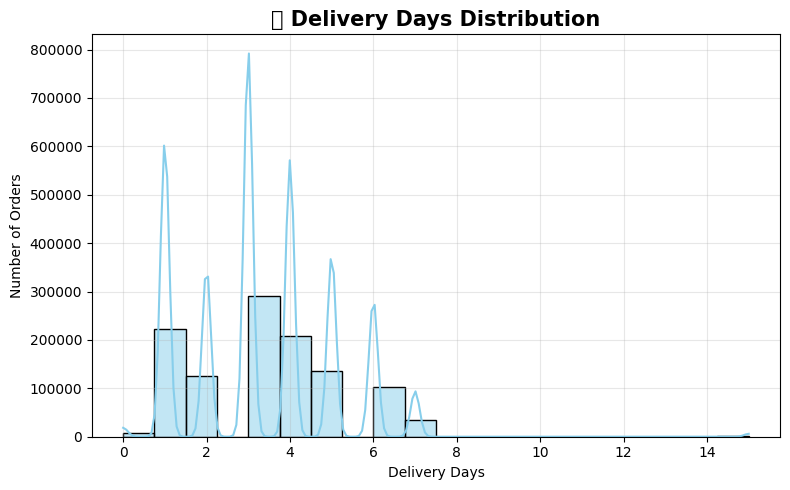

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\99532993.py:33: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


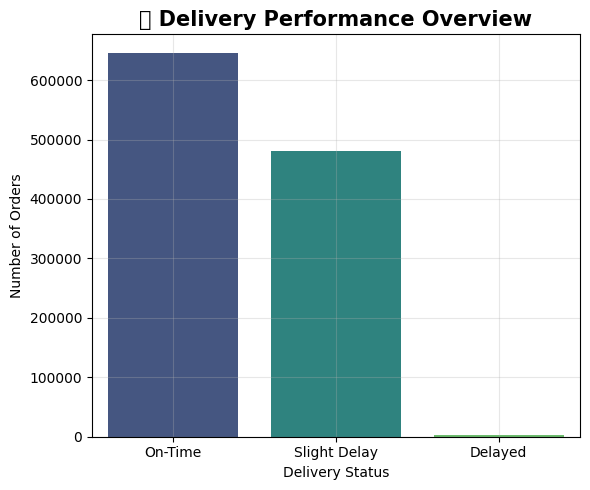

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\99532993.py:44: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


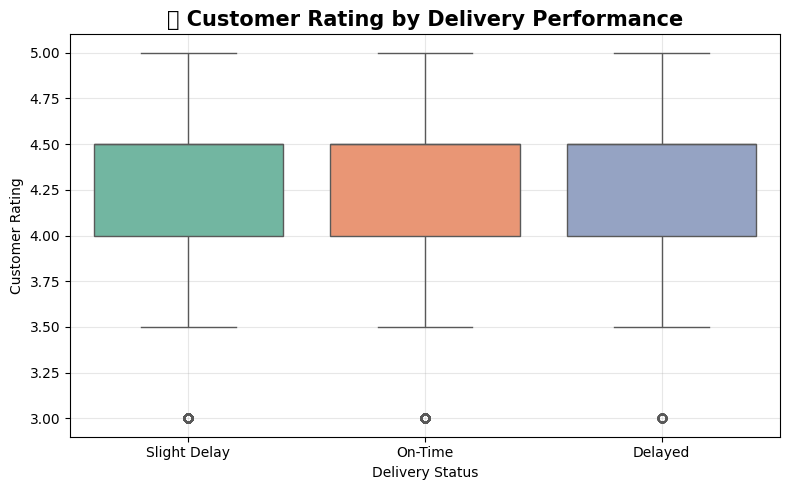

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\99532993.py:61: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


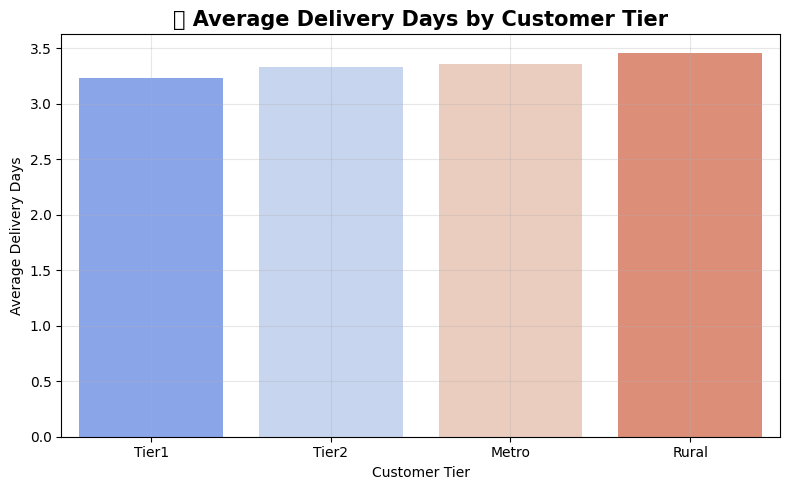

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\99532993.py:75: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


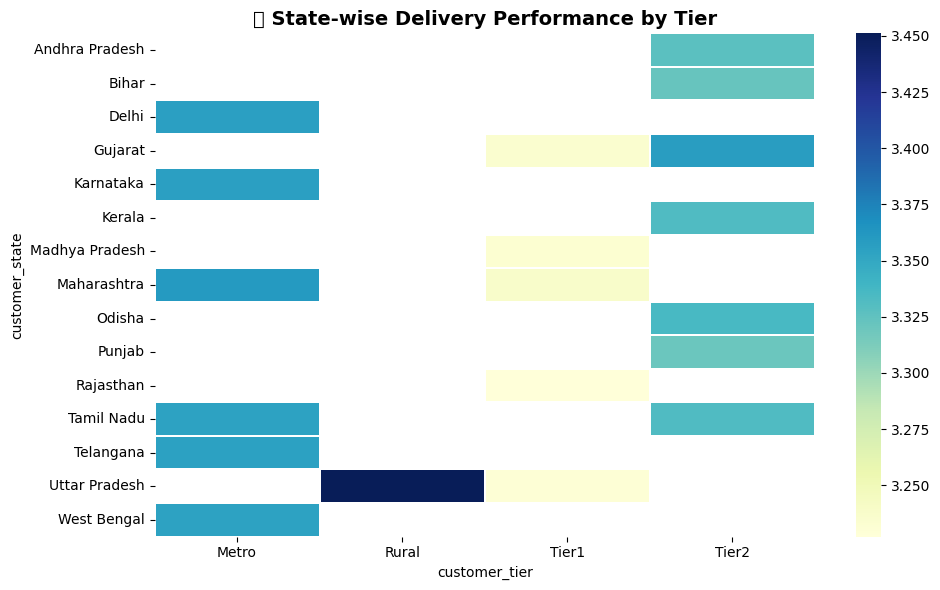

In [16]:
# =====================================
# 🚚 DELIVERY PERFORMANCE ANALYSIS
# =====================================

# Ensure required columns exist
required_cols = ['delivery_days', 'customer_rating', 'customer_tier', 'customer_state']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Delivery Days Distribution ---
    plt.figure(figsize=(8,5))
    sns.histplot(df['delivery_days'], bins=20, kde=True, color='skyblue')
    plt.title("📦 Delivery Days Distribution", fontsize=15, weight='bold')
    plt.xlabel("Delivery Days")
    plt.ylabel("Number of Orders")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ On-Time vs Delayed Delivery ---
    df['delivery_status'] = np.where(df['delivery_days'] <= 3, 'On-Time',
                            np.where(df['delivery_days'] <= 7, 'Slight Delay', 'Delayed'))

    delivery_counts = df['delivery_status'].value_counts().reset_index()
    delivery_counts.columns = ['delivery_status', 'count']  # rename columns

    plt.figure(figsize=(6,5))
    sns.barplot(data=delivery_counts, x='delivery_status', y='count', palette='viridis')
    plt.title("⏰ Delivery Performance Overview", fontsize=15, weight='bold')
    plt.xlabel("Delivery Status")
    plt.ylabel("Number of Orders")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


    # --- 3️⃣ Correlation: Delivery Speed vs Rating ---
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='delivery_status', y='customer_rating', palette='Set2')
    plt.title("⭐ Customer Rating by Delivery Performance", fontsize=15, weight='bold')
    plt.xlabel("Delivery Status")
    plt.ylabel("Customer Rating")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Tier-wise Average Delivery Days ---
    tier_delivery = (
        df.groupby('customer_tier')['delivery_days']
        .mean()
        .sort_values()
        .reset_index()
    )

    plt.figure(figsize=(8,5))
    sns.barplot(data=tier_delivery, x='customer_tier', y='delivery_days', palette='coolwarm')
    plt.title("🏙️ Average Delivery Days by Customer Tier", fontsize=15, weight='bold')
    plt.xlabel("Customer Tier")
    plt.ylabel("Average Delivery Days")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 5️⃣ Optional: State-wise Delivery Heatmap ---
    delivery_state = (
        df.groupby(['customer_state', 'customer_tier'])['delivery_days']
        .mean()
        .reset_index()
        .pivot_table(index='customer_state', columns='customer_tier', values='delivery_days')
    )

    plt.figure(figsize=(10,6))
    sns.heatmap(delivery_state, cmap='YlGnBu', linewidths=0.3, annot=False)
    plt.title("🗺️ State-wise Delivery Performance by Tier", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


## 🔄 Question 12: Return Patterns & Customer Satisfaction Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\629972052.py:19: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


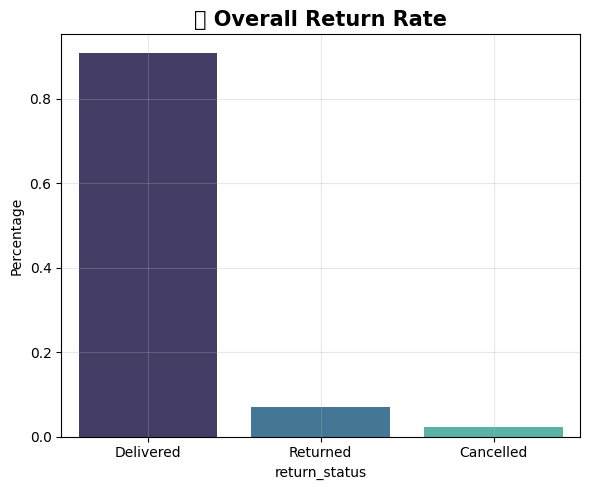

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\629972052.py:37: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


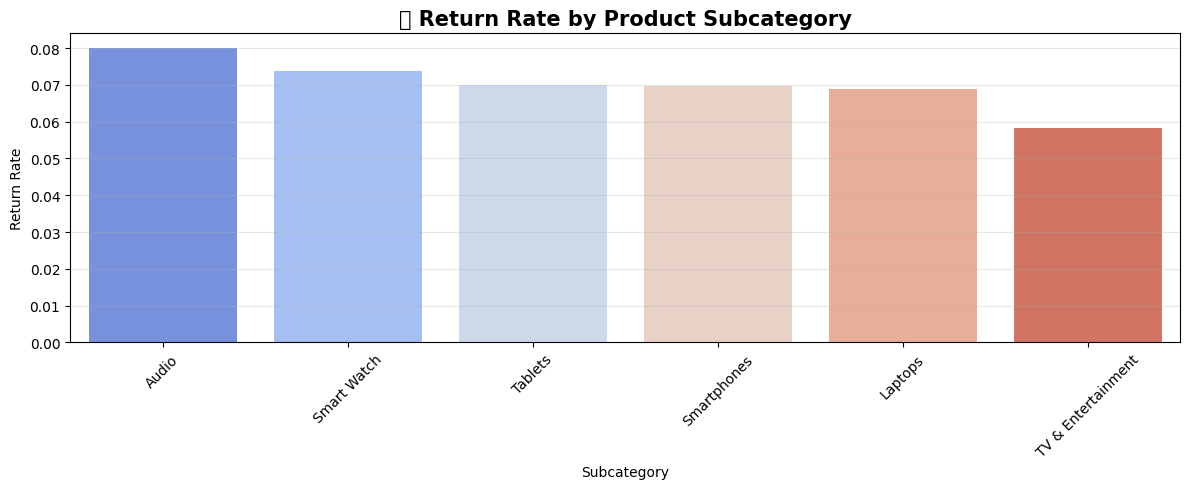

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\629972052.py:47: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


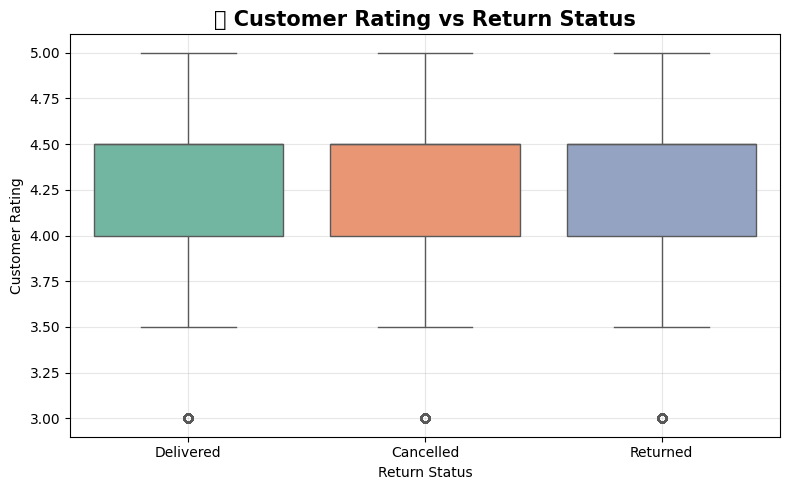

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\629972052.py:58: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


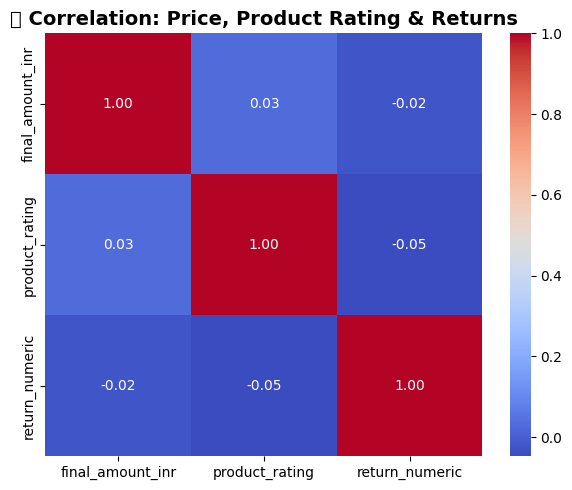

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\629972052.py:76: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


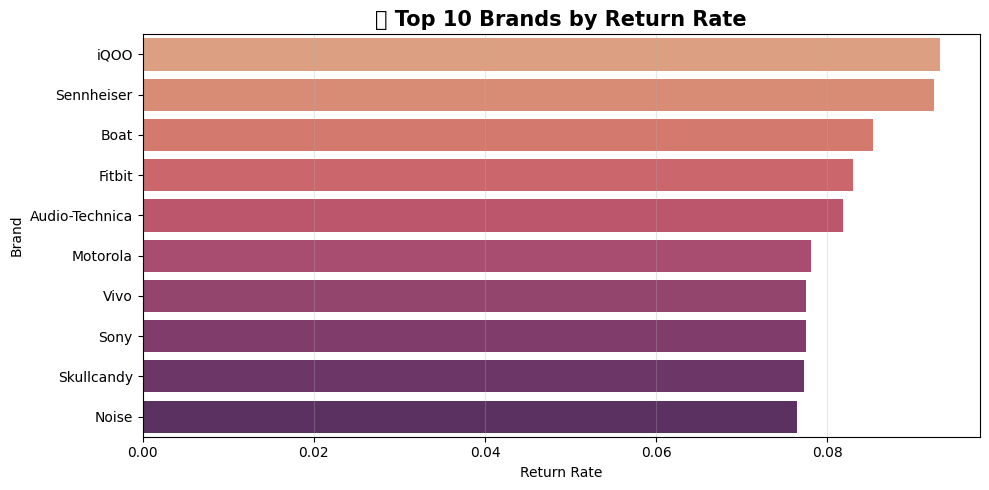

In [18]:
# =====================================
# 🔄 RETURN PATTERNS & CUSTOMER SATISFACTION (Subcategory Analysis)
# =====================================

# Ensure required columns exist
required_cols = ['return_status', 'customer_rating', 'subcategory', 'product_rating', 'final_amount_inr', 'brand']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Overall Return Rate ---
    return_rate = df['return_status'].value_counts(normalize=True).reset_index()
    return_rate.columns = ['return_status', 'percentage']

    plt.figure(figsize=(6,5))
    sns.barplot(data=return_rate, x='return_status', y='percentage', palette='mako')
    plt.title("🔁 Overall Return Rate", fontsize=15, weight='bold')
    plt.ylabel("Percentage")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Return Rate by Subcategory ---
    subcat_return = (
        df.groupby('subcategory')['return_status']
        .apply(lambda x: (x=='Returned').sum() / len(x))
        .reset_index(name='return_rate')
        .sort_values('return_rate', ascending=False)
    )

    plt.figure(figsize=(12,5))
    sns.barplot(data=subcat_return, x='subcategory', y='return_rate', palette='coolwarm')
    plt.title("📦 Return Rate by Product Subcategory", fontsize=15, weight='bold')
    plt.xlabel("Subcategory")
    plt.ylabel("Return Rate")
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Returns vs Customer Ratings ---
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='return_status', y='customer_rating', palette='Set2')
    plt.title("⭐ Customer Rating vs Return Status", fontsize=15, weight='bold')
    plt.xlabel("Return Status")
    plt.ylabel("Customer Rating")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Returns vs Price & Product Rating Correlation ---
    corr_data = df[['final_amount_inr', 'product_rating', 'return_status']].copy()
    corr_data['return_numeric'] = np.where(corr_data['return_status']=='Returned', 1, 0)
    corr_matrix = corr_data[['final_amount_inr', 'product_rating', 'return_numeric']].corr()

    plt.figure(figsize=(6,5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("🔍 Correlation: Price, Product Rating & Returns", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- 5️⃣ Top Brands with Highest Return Rates ---
    brand_return = (
        df.groupby('brand')['return_status']
        .apply(lambda x: (x=='Returned').sum() / len(x))
        .reset_index(name='return_rate')
        .sort_values('return_rate', ascending=False)
        .head(10)
    )

    plt.figure(figsize=(10,5))
    sns.barplot(data=brand_return, x='return_rate', y='brand', palette='flare')
    plt.title("🏷️ Top 10 Brands by Return Rate", fontsize=15, weight='bold')
    plt.xlabel("Return Rate")
    plt.ylabel("Brand")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()



## 🏷️ Question 13: Brand Performance & Market Share Evolution

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\742449919.py:19: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


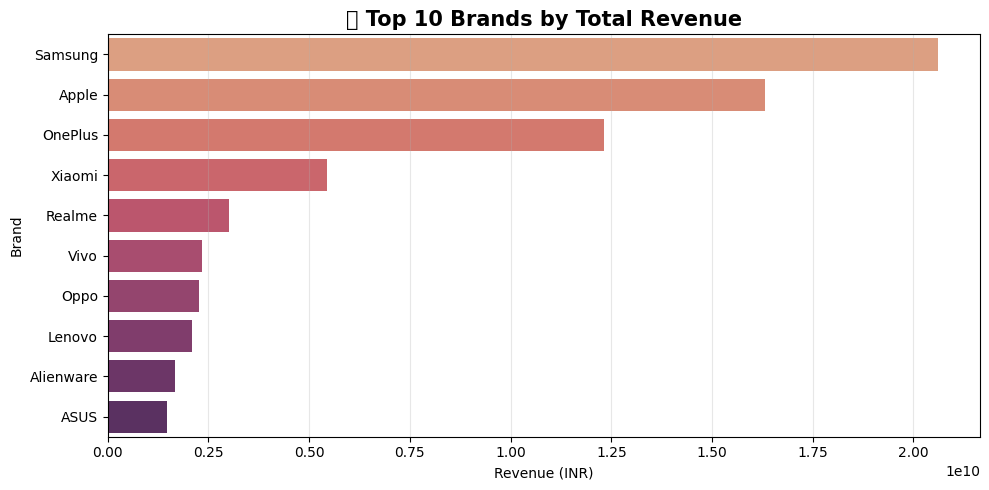

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\742449919.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


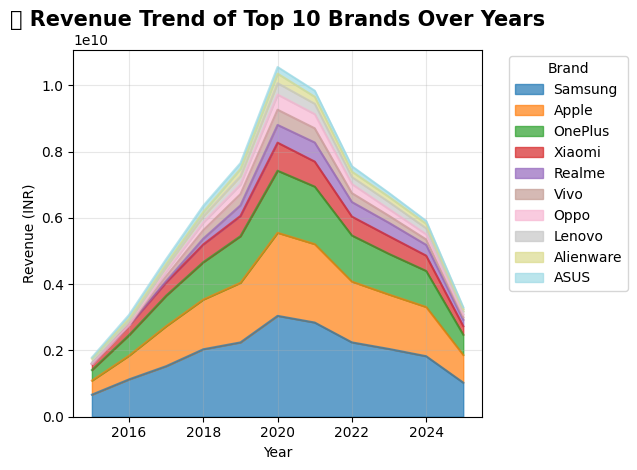

C:\Users\desik\AppData\Local\Temp\ipykernel_31632\742449919.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


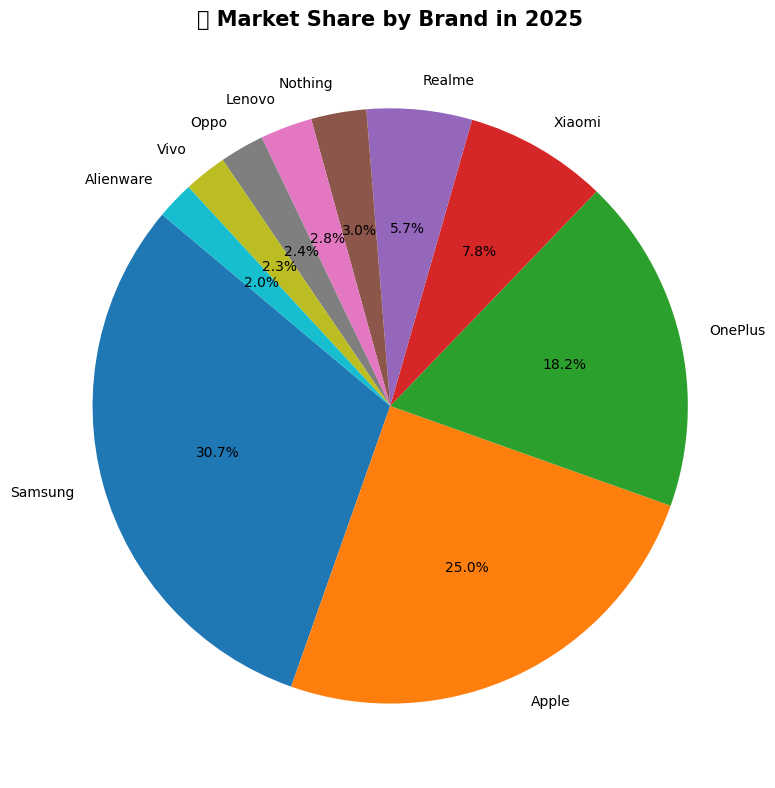

In [27]:
# =====================================
# 🏷️ BRAND PERFORMANCE & MARKET SHARE EVOLUTION
# =====================================

# Ensure required columns exist
required_cols = ['brand', 'final_amount_inr', 'order_year', 'subcategory']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Total Revenue by Brand ---
    brand_revenue = df.groupby('brand')['final_amount_inr'].sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=brand_revenue.values, y=brand_revenue.index, palette='flare')
    plt.title("💰 Top 10 Brands by Total Revenue", fontsize=15, weight='bold')
    plt.xlabel("Revenue (INR)")
    plt.ylabel("Brand")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Brand Revenue Trend Over Years (Stacked Area) ---
    brand_yearly = (
        df.groupby(['order_year', 'brand'])['final_amount_inr']
        .sum()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )

    brand_yearly_top = brand_yearly[brand_revenue.index]  # Only top 10 brands

    plt.figure(figsize=(12,6))
    brand_yearly_top.plot(kind='area', stacked=True, cmap='tab20', alpha=0.7)
    plt.title("📈 Revenue Trend of Top 10 Brands Over Years", fontsize=15, weight='bold')
    plt.xlabel("Year")
    plt.ylabel("Revenue (INR)")
    plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Market Share by Brand (Most Recent Year) ---
    latest_year = df['order_year'].max()
    latest_brand = df[df['order_year']==latest_year].groupby('brand')['final_amount_inr'].sum()
    latest_brand = latest_brand.sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,8))
    plt.pie(latest_brand.values, labels=latest_brand.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('tab10'))
    plt.title(f"📊 Market Share by Brand in {latest_year}", fontsize=15, weight='bold')
    plt.tight_layout()
    plt.show()



## 💰 Question 14: Customer Lifetime Value (CLV) Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\1254778671.py:33: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


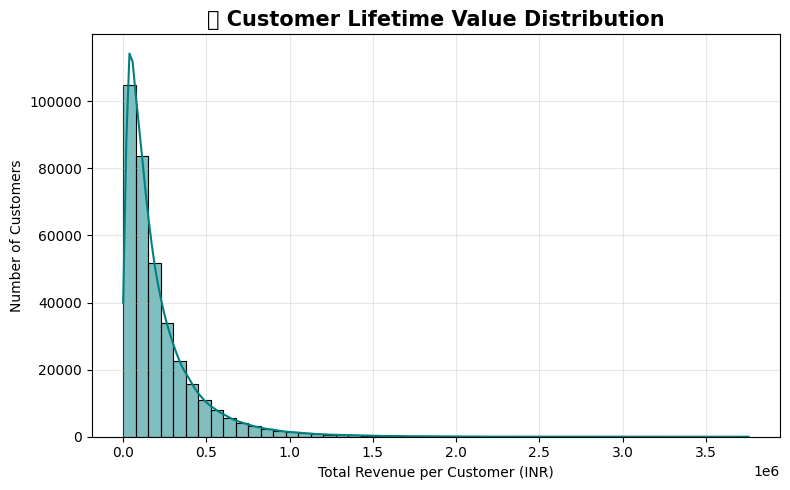

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\1254778671.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


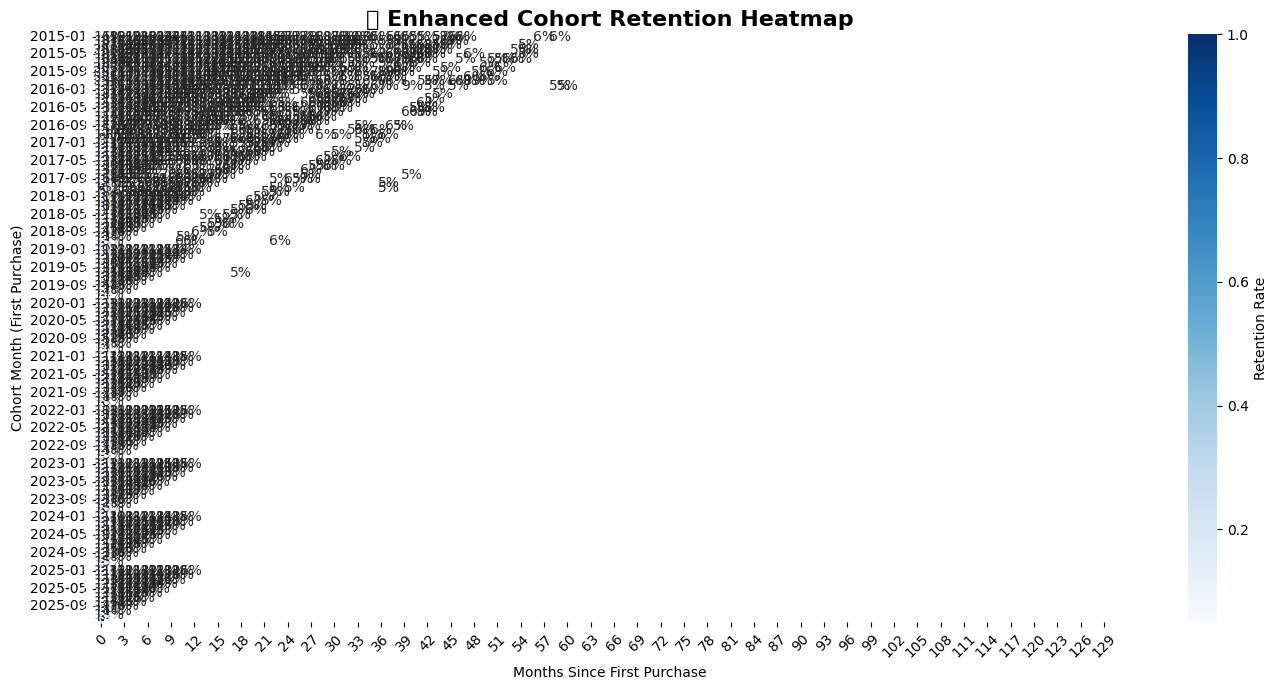

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\1254778671.py:84: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


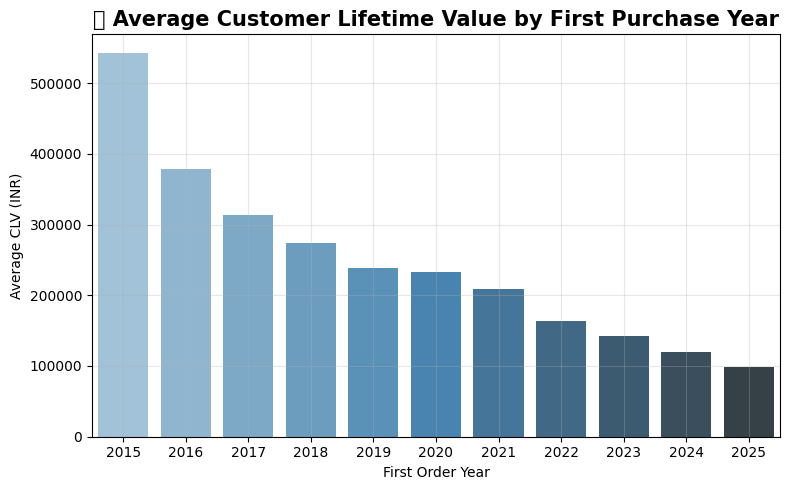

In [8]:
# =====================================
# 💰 CUSTOMER LIFETIME VALUE (CLV) ANALYSIS
# =====================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure required columns exist
required_cols = ['customer_id', 'order_date', 'final_amount_inr', 'order_year', 'transaction_id']

if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:
    # --- 1️⃣ Create Cohort: Customer First Purchase Year ---
    df['first_order_year'] = df.groupby('customer_id')['order_date'].transform('min').dt.year

    # --- 2️⃣ Calculate CLV per Customer ---
    clv = df.groupby('customer_id').agg(
        first_order_year=('first_order_year', 'first'),
        total_orders=('transaction_id', 'count'),
        total_revenue=('final_amount_inr', 'sum')
    ).reset_index()

    # --- 3️⃣ CLV Distribution ---
    plt.figure(figsize=(8,5))
    sns.histplot(clv['total_revenue'], bins=50, kde=True, color='teal')
    plt.title("💵 Customer Lifetime Value Distribution", fontsize=15, weight='bold')
    plt.xlabel("Total Revenue per Customer (INR)")
    plt.ylabel("Number of Customers")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Cohort Month and Order Month ---
    df['cohort_month'] = df.groupby('customer_id')['order_date'].transform('min').dt.to_period('M')
    df['order_month'] = df['order_date'].dt.to_period('M')

    # --- Count unique customers per cohort per month ---
    cohort_data = df.groupby(['cohort_month', 'order_month'])['customer_id'].nunique().reset_index()

    # --- Create cohort index (month offset from first purchase) ---
    cohort_data['period_number'] = (cohort_data['order_month'].dt.year - cohort_data['cohort_month'].dt.year) * 12 + \
                                    (cohort_data['order_month'].dt.month - cohort_data['cohort_month'].dt.month)

    # --- Pivot table: rows = cohort_month, columns = period_number ---
    cohort_counts = cohort_data.pivot(index='cohort_month', columns='period_number', values='customer_id')

    # --- Normalize by first column (month 0) ---
    cohort_sizes = cohort_counts.iloc[:,0]
    cohort_retention = cohort_counts.divide(cohort_sizes, axis=0)

    # --- 4️⃣ Enhanced Cohort Retention Heatmap ---
    mask = cohort_retention < 0.05  # mask very low retention (<5%)

    plt.figure(figsize=(14,7))
    sns.heatmap(
        cohort_retention,
        cmap='Blues',
        annot=True,
        fmt=".0%",
        linewidths=0.3,
        mask=mask,
        cbar_kws={'label': 'Retention Rate'}
    )
    plt.title("📊 Enhanced Cohort Retention Heatmap", fontsize=16, weight='bold')
    plt.xlabel("Months Since First Purchase")
    plt.ylabel("Cohort Month (First Purchase)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- 5️⃣ Average CLV by First Order Year ---
    avg_clv_year = clv.groupby('first_order_year')['total_revenue'].mean().reset_index()

    plt.figure(figsize=(8,5))
    sns.barplot(data=avg_clv_year, x='first_order_year', y='total_revenue', palette='Blues_d')
    plt.title("📈 Average Customer Lifetime Value by First Purchase Year", fontsize=15, weight='bold')
    plt.xlabel("First Order Year")
    plt.ylabel("Average CLV (INR)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 📊 Question 15: Discount & Promotional Effectiveness Analysis

Correlation matrix:
                avg_discount  total_sales  total_revenue
avg_discount       1.000000     0.001948      -0.048337
total_sales        0.001948     1.000000       0.975395
total_revenue     -0.048337     0.975395       1.000000


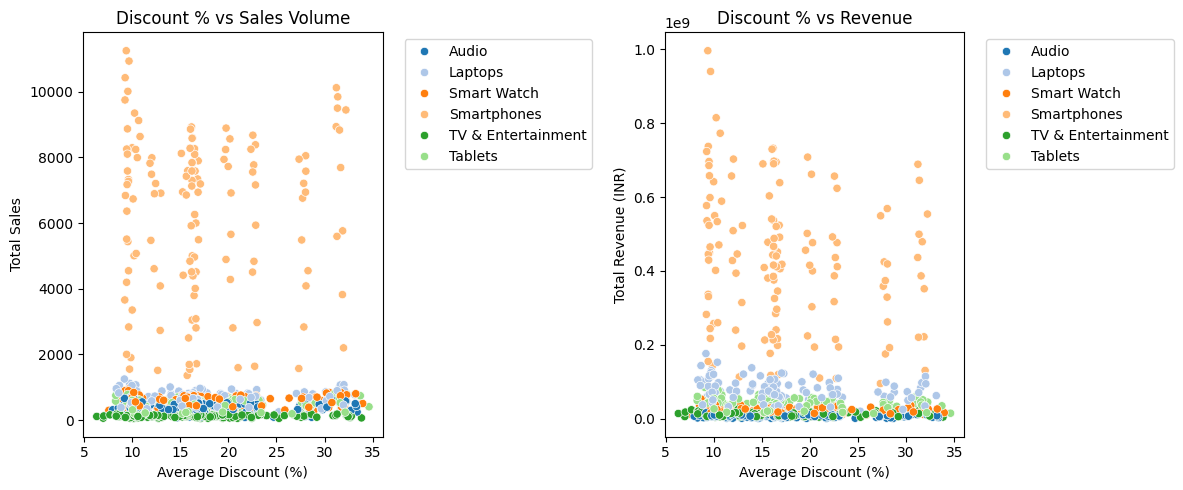

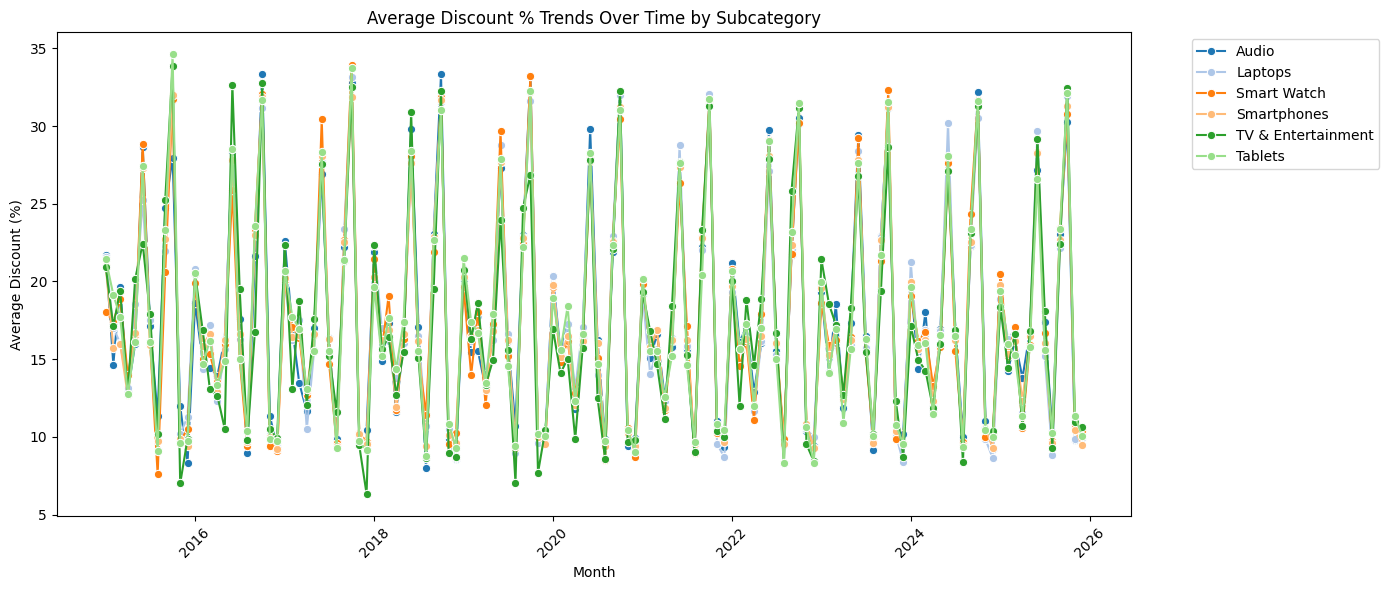

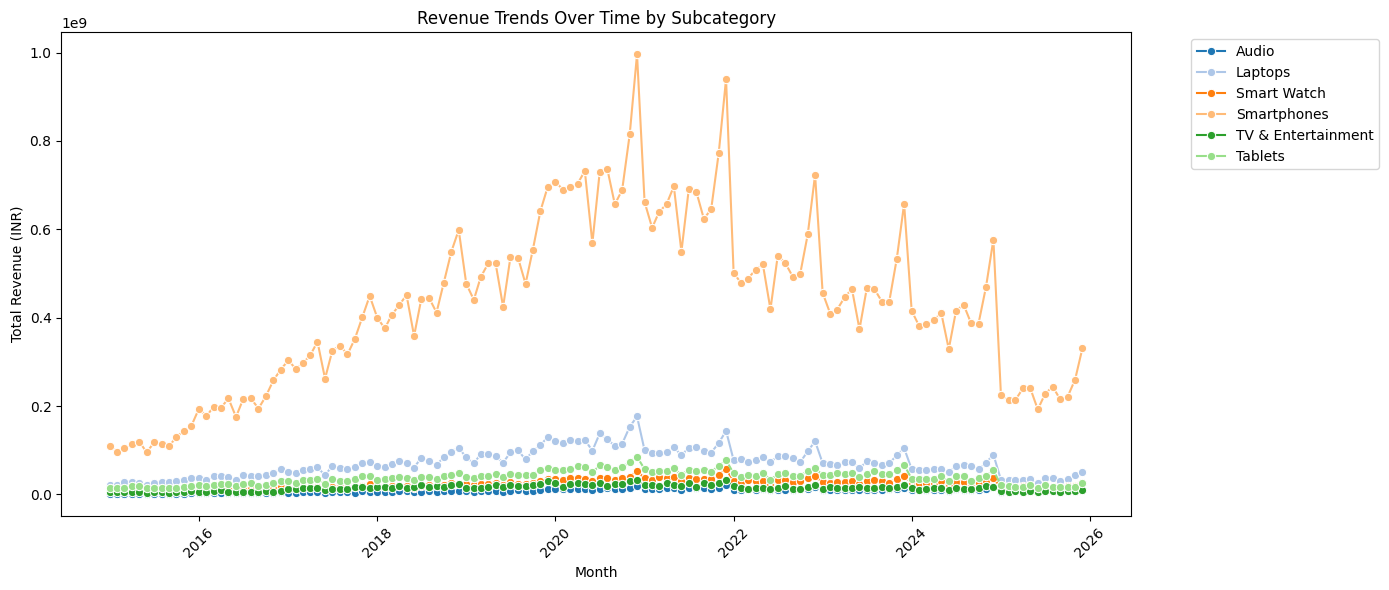

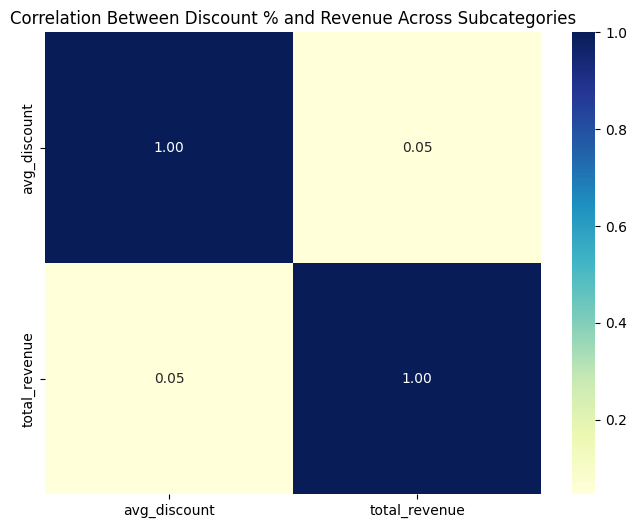

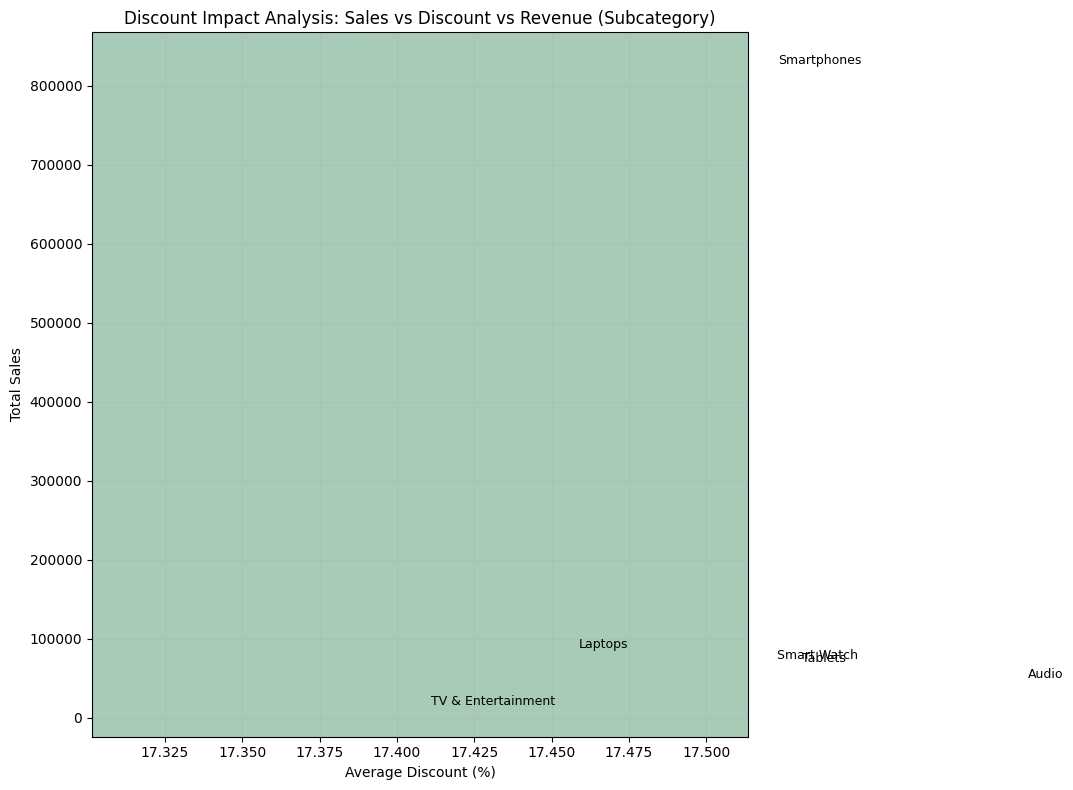

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure required columns exist ---
required_cols = ['order_date', 'subcategory', 'final_amount_inr', 'discount_percent', 'transaction_id']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing one or more required columns:", required_cols)
else:

    # 1️⃣ Preprocessing
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['order_month'] = df['order_date'].dt.to_period('M')
    df['order_month_dt'] = df['order_month'].dt.to_timestamp()  # for plotting

    # 2️⃣ Aggregate data by month & subcategory
    discount_data = df.groupby(['order_month', 'subcategory']).agg(
        total_revenue=('final_amount_inr', 'sum'),
        total_sales=('transaction_id', 'count'),
        avg_discount=('discount_percent', 'mean')
    ).reset_index()
    discount_data['order_month_dt'] = discount_data['order_month'].dt.to_timestamp()

    # 3️⃣ Correlation matrix
    corr = discount_data[['avg_discount', 'total_sales', 'total_revenue']].corr()
    print("Correlation matrix:\n", corr)

    # 4️⃣ Scatter plots: Discount % vs Sales & Revenue
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.scatterplot(data=discount_data, x='avg_discount', y='total_sales', hue='subcategory', palette='tab20')
    plt.title("Discount % vs Sales Volume")
    plt.xlabel("Average Discount (%)")
    plt.ylabel("Total Sales")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')

    plt.subplot(1,2,2)
    sns.scatterplot(data=discount_data, x='avg_discount', y='total_revenue', hue='subcategory', palette='tab20')
    plt.title("Discount % vs Revenue")
    plt.xlabel("Average Discount (%)")
    plt.ylabel("Total Revenue (INR)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 5️⃣ Line plots: Discount & Revenue trends over time
    plt.figure(figsize=(14,6))
    sns.lineplot(data=discount_data, x='order_month_dt', y='avg_discount', hue='subcategory', marker='o', palette='tab20')
    plt.title("Average Discount % Trends Over Time by Subcategory")
    plt.xlabel("Month")
    plt.ylabel("Average Discount (%)")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14,6))
    sns.lineplot(data=discount_data, x='order_month_dt', y='total_revenue', hue='subcategory', marker='o', palette='tab20')
    plt.title("Revenue Trends Over Time by Subcategory")
    plt.xlabel("Month")
    plt.ylabel("Total Revenue (INR)")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 6️⃣ Heatmap: Correlation Discount % vs Revenue
    heatmap_data = discount_data.pivot_table(index='subcategory', values=['avg_discount','total_revenue'], aggfunc='mean')
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title("Correlation Between Discount % and Revenue Across Subcategories")
    plt.show()

    # 7️⃣ Bubble Chart: Sales vs Discount vs Revenue
    bubble_data = df.groupby('subcategory').agg(
        total_revenue=('final_amount_inr', 'sum'),
        total_sales=('transaction_id', 'count'),
        avg_discount=('discount_percent', 'mean')
    ).reset_index()

    plt.figure(figsize=(12,8))
    plt.scatter(
        x=bubble_data['avg_discount'],
        y=bubble_data['total_sales'],
        s=bubble_data['total_revenue'] / 1000,  # bubble size scaled
        c=range(len(bubble_data)),               # color per subcategory
        cmap='tab20',
        alpha=0.7,
        edgecolors='w'
    )

    for i, row in bubble_data.iterrows():
        plt.text(row['avg_discount'] + 0.1, row['total_sales'], row['subcategory'], fontsize=9)

    plt.title("Discount Impact Analysis: Sales vs Discount vs Revenue (Subcategory)")
    plt.xlabel("Average Discount (%)")
    plt.ylabel("Total Sales")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



## ⭐ Question 16: Product Rating Analysis and Impact on Sales

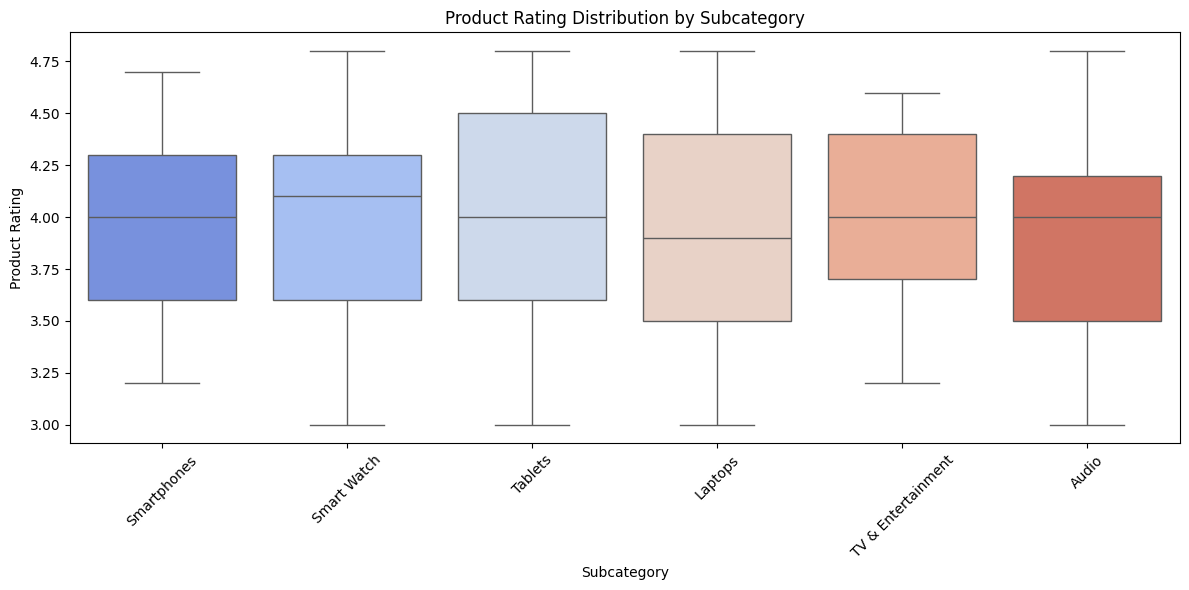

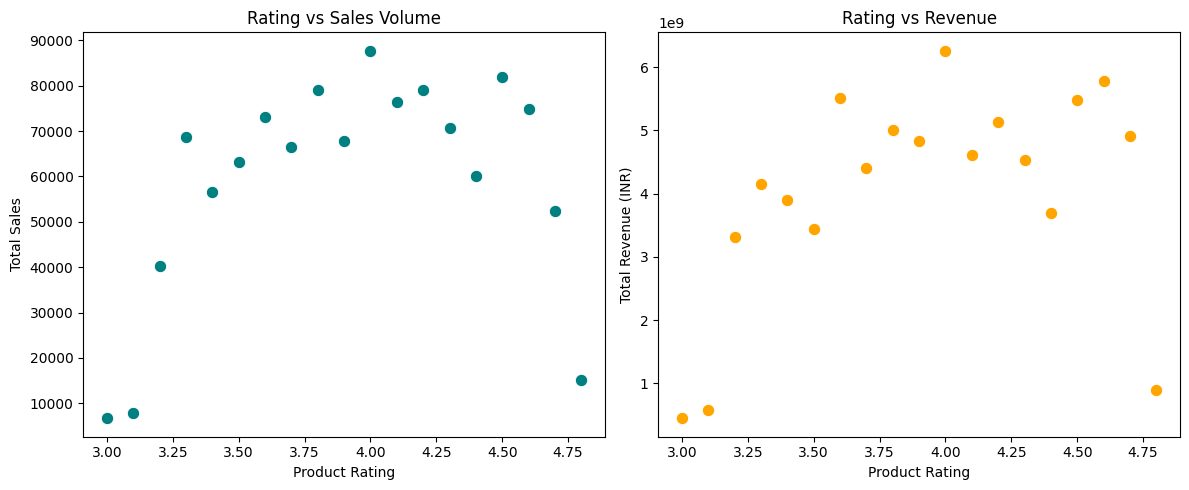

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\2365593397.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data['transaction_id'] = pd.to_numeric(corr_data['transaction_id'], errors='coerce')


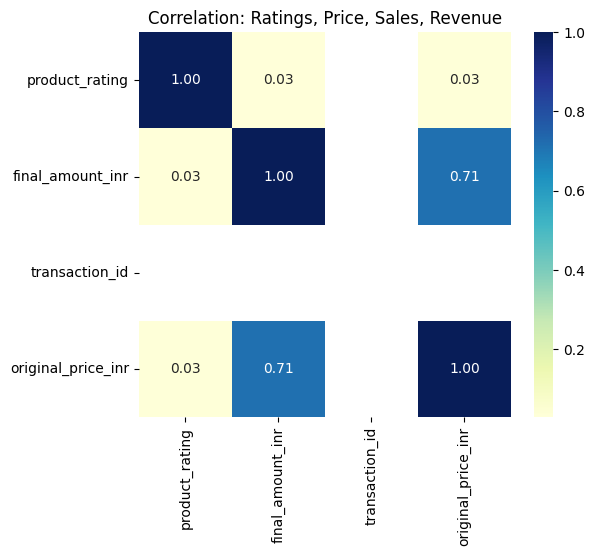

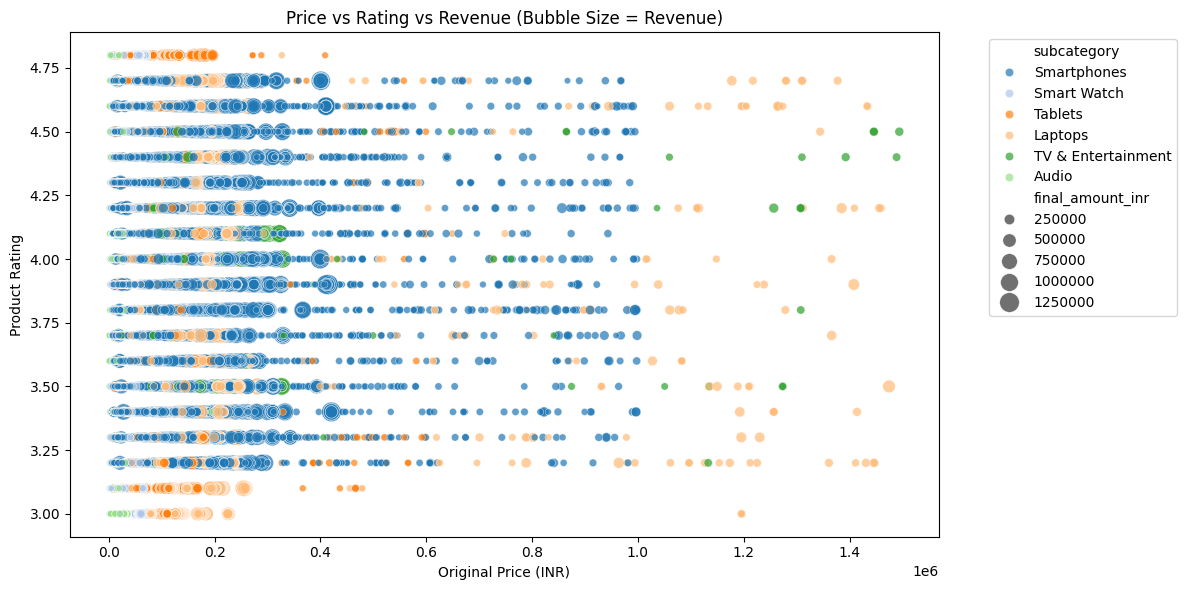

In [15]:
# =====================================
# ⭐ PRODUCT RATING ANALYSIS & SALES IMPACT
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure required columns exist ---
required_cols = ['subcategory', 'product_rating', 'final_amount_inr', 'transaction_id', 'original_price_inr']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing required columns:", required_cols)
else:

    # --- 1️⃣ Rating Distribution by Subcategory ---
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x='subcategory', y='product_rating', palette='coolwarm')
    plt.title("Product Rating Distribution by Subcategory")
    plt.xlabel("Subcategory")
    plt.ylabel("Product Rating")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Rating vs Sales/Revenue Correlation ---
    rating_data = df.groupby('product_rating').agg(
        total_sales=('transaction_id', 'count'),
        total_revenue=('final_amount_inr', 'sum')
    ).reset_index()

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.scatterplot(data=rating_data, x='product_rating', y='total_sales', color='teal', s=80)
    plt.title("Rating vs Sales Volume")
    plt.xlabel("Product Rating")
    plt.ylabel("Total Sales")

    plt.subplot(1,2,2)
    sns.scatterplot(data=rating_data, x='product_rating', y='total_revenue', color='orange', s=80)
    plt.title("Rating vs Revenue")
    plt.xlabel("Product Rating")
    plt.ylabel("Total Revenue (INR)")
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Correlation Heatmap ---
    corr_data = df[['product_rating', 'final_amount_inr', 'transaction_id', 'original_price_inr']]
    corr_data['transaction_id'] = pd.to_numeric(corr_data['transaction_id'], errors='coerce')
    corr_matrix = corr_data.corr()

    plt.figure(figsize=(6,5))
    sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title("Correlation: Ratings, Price, Sales, Revenue")
    plt.show()

    # --- 4️⃣ Price vs Rating vs Revenue Analysis ---
    plt.figure(figsize=(12,6))
    sns.scatterplot(
        data=df,
        x='original_price_inr',
        y='product_rating',
        size='final_amount_inr',
        hue='subcategory',
        palette='tab20',
        alpha=0.7,
        sizes=(20, 200)
    )
    plt.title("Price vs Rating vs Revenue (Bubble Size = Revenue)")
    plt.xlabel("Original Price (INR)")
    plt.ylabel("Product Rating")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()


## 🛒 Question 17: Customer Journey Analysis

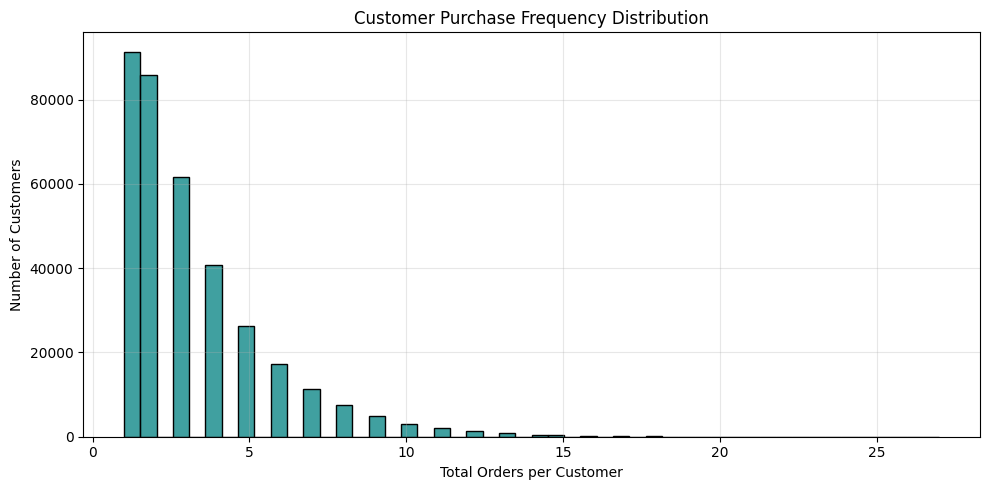

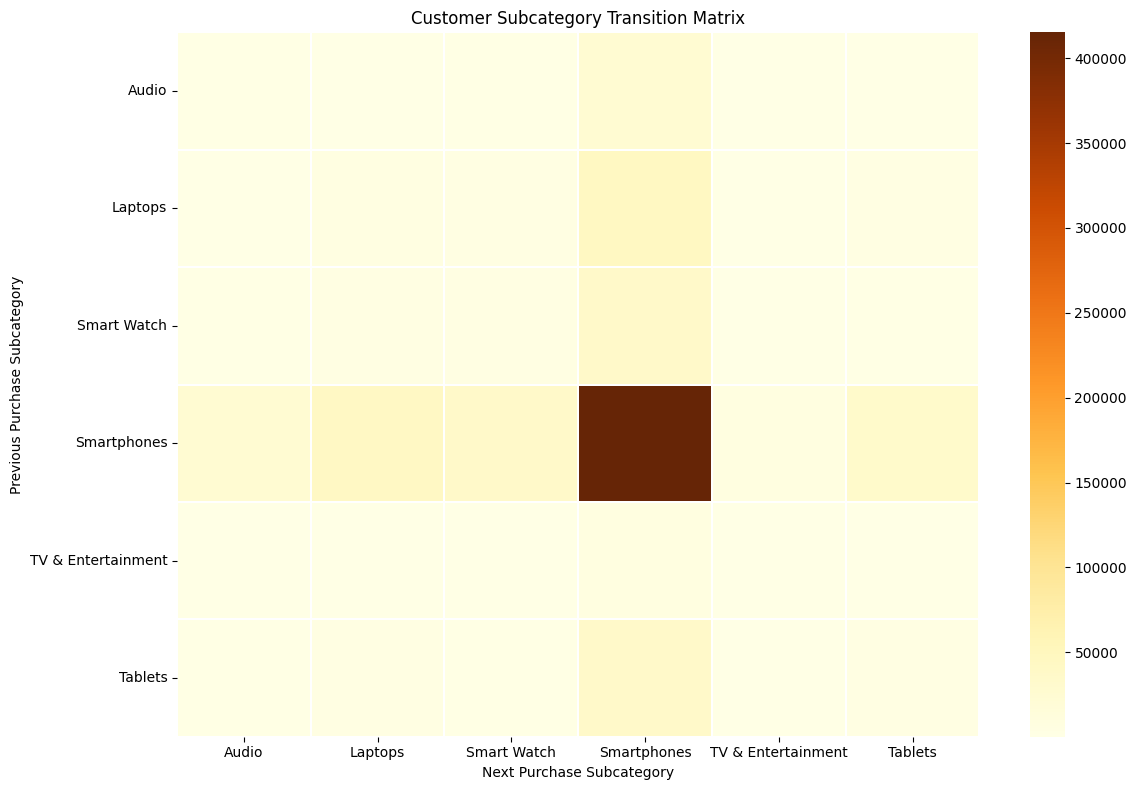

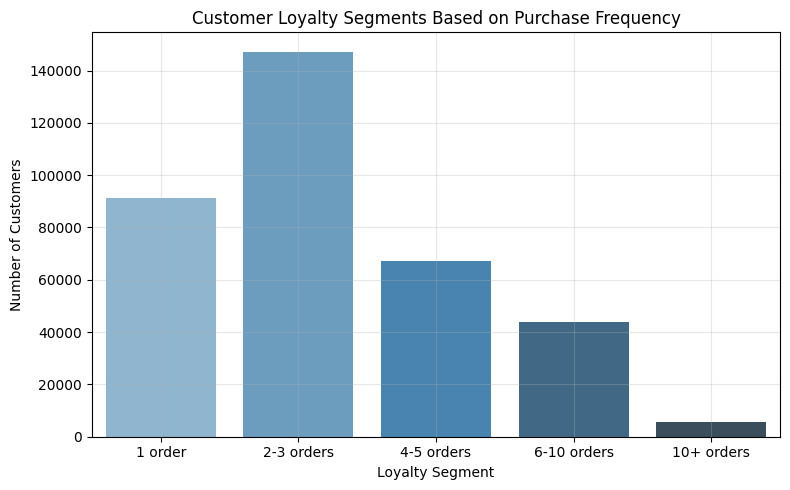

In [16]:
# =====================================
# 🛒 CUSTOMER JOURNEY ANALYSIS
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure required columns exist ---
required_cols = ['customer_id', 'order_date', 'subcategory', 'transaction_id']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing required columns:", required_cols)
else:

    # --- 1️⃣ Purchase Frequency per Customer ---
    customer_freq = df.groupby('customer_id')['transaction_id'].count().reset_index()
    customer_freq.columns = ['customer_id', 'total_orders']

    plt.figure(figsize=(10,5))
    sns.histplot(customer_freq['total_orders'], bins=50, kde=False, color='teal')
    plt.title("Customer Purchase Frequency Distribution")
    plt.xlabel("Total Orders per Customer")
    plt.ylabel("Number of Customers")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ Subcategory Transition Matrix ---
    # Sort orders by customer and date
    df_sorted = df.sort_values(['customer_id', 'order_date'])
    
    # For each customer, get consecutive purchases
    transitions = []
    for cust, group in df_sorted.groupby('customer_id'):
        subcats = group['subcategory'].tolist()
        for i in range(len(subcats)-1):
            transitions.append((subcats[i], subcats[i+1]))
    
    trans_df = pd.DataFrame(transitions, columns=['from_subcategory', 'to_subcategory'])
    transition_matrix = trans_df.groupby(['from_subcategory', 'to_subcategory']).size().unstack(fill_value=0)

    plt.figure(figsize=(12,8))
    sns.heatmap(transition_matrix, cmap='YlOrBr', linewidths=0.3)
    plt.title("Customer Subcategory Transition Matrix")
    plt.xlabel("Next Purchase Subcategory")
    plt.ylabel("Previous Purchase Subcategory")
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Customer Loyalty Segmentation ---
    bins = [0, 1, 3, 5, 10, 1000]
    labels = ['1 order', '2-3 orders', '4-5 orders', '6-10 orders', '10+ orders']
    customer_freq['loyalty_segment'] = pd.cut(customer_freq['total_orders'], bins=bins, labels=labels, right=True)

    loyalty_counts = customer_freq['loyalty_segment'].value_counts().sort_index()

    plt.figure(figsize=(8,5))
    sns.barplot(x=loyalty_counts.index, y=loyalty_counts.values, palette='Blues_d')
    plt.title("Customer Loyalty Segments Based on Purchase Frequency")
    plt.xlabel("Loyalty Segment")
    plt.ylabel("Number of Customers")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## 📦 Question 18: Inventory and Product Lifecycle Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\4231219601.py:36: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


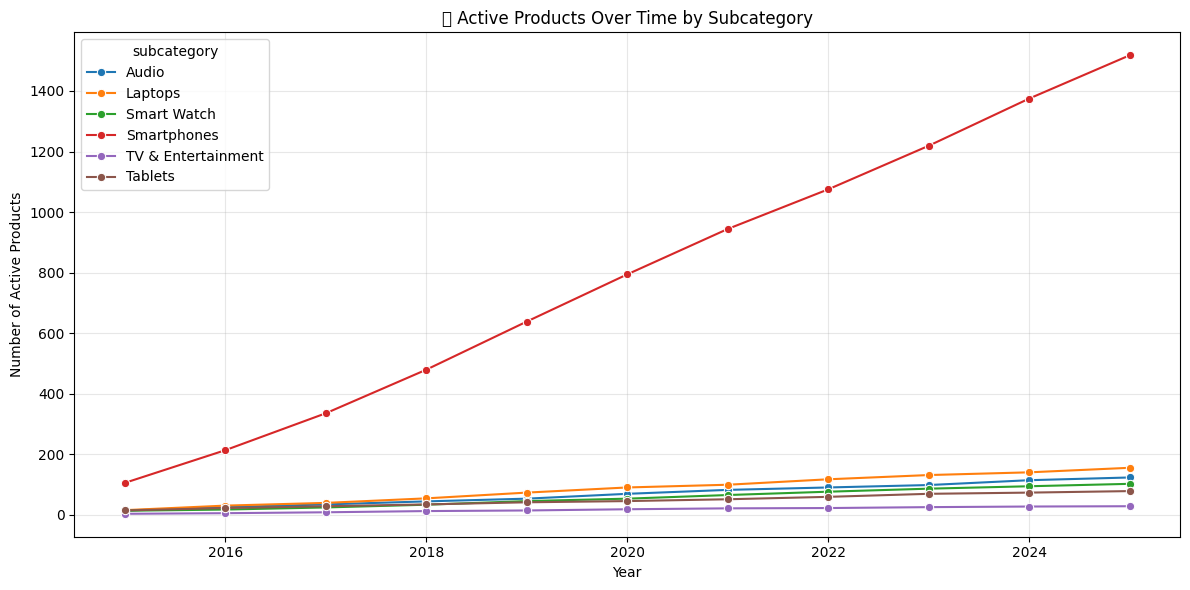

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\4231219601.py:46: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


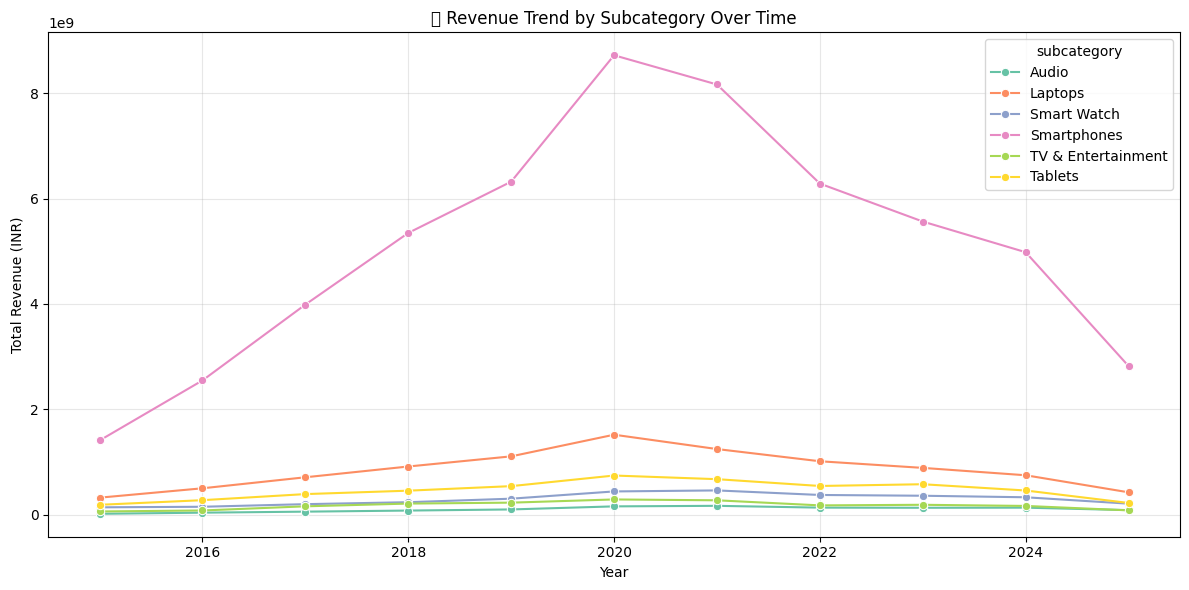

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\4231219601.py:68: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


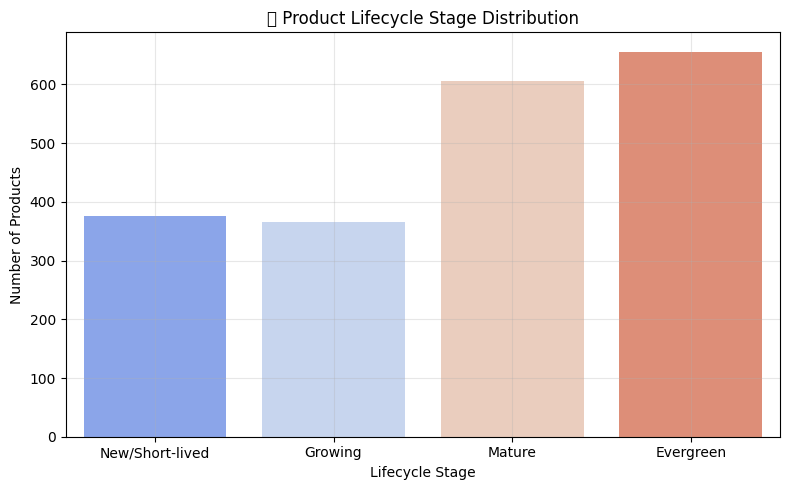

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\4231219601.py:81: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


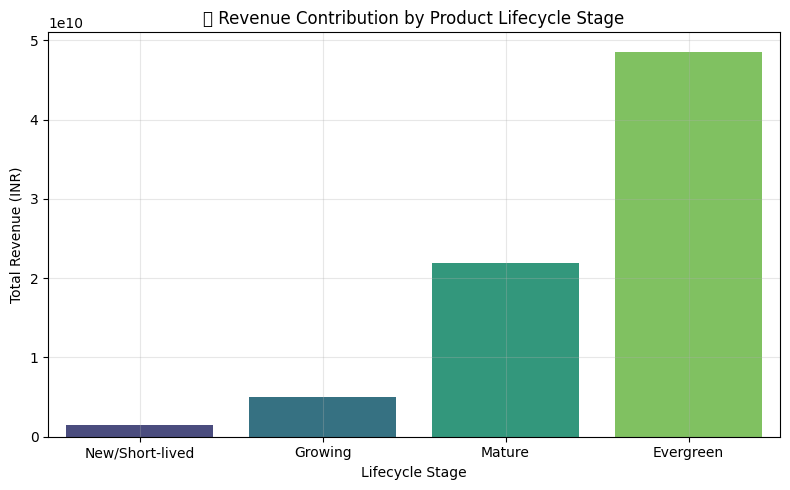

In [17]:
# =====================================
# 📦 PRODUCT LIFECYCLE & INVENTORY ANALYSIS
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure required columns exist ---
required_cols = ['product_id', 'subcategory', 'order_year', 'final_amount_inr', 'quantity']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing required columns:", required_cols)
else:

    # --- 1️⃣ Product Launch Year ---
    product_launch = df.groupby('product_id')['order_year'].min().reset_index()
    product_launch.columns = ['product_id', 'launch_year']

    # Merge back to main df
    df = df.merge(product_launch, on='product_id', how='left')

    # --- 2️⃣ Annual Product Performance ---
    product_yearly = df.groupby(['order_year', 'subcategory']).agg(
        total_sales=('quantity', 'sum'),
        total_revenue=('final_amount_inr', 'sum'),
        active_products=('product_id', pd.Series.nunique)
    ).reset_index()

    # --- 3️⃣ Product Count Trend by Year ---
    plt.figure(figsize=(12,6))
    sns.lineplot(data=product_yearly, x='order_year', y='active_products', hue='subcategory', marker='o', palette='tab10')
    plt.title("📦 Active Products Over Time by Subcategory")
    plt.xlabel("Year")
    plt.ylabel("Number of Active Products")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Revenue Trend by Subcategory ---
    plt.figure(figsize=(12,6))
    sns.lineplot(data=product_yearly, x='order_year', y='total_revenue', hue='subcategory', marker='o', palette='Set2')
    plt.title("💰 Revenue Trend by Subcategory Over Time")
    plt.xlabel("Year")
    plt.ylabel("Total Revenue (INR)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 5️⃣ Product Lifecycle Classification ---
    # Define lifecycle stages based on product activity years
    product_activity = df.groupby('product_id')['order_year'].agg(['min', 'max', 'nunique']).reset_index()
    product_activity['lifecycle_stage'] = pd.cut(
        product_activity['nunique'],
        bins=[0, 2, 4, 7, 11],
        labels=['New/Short-lived', 'Growing', 'Mature', 'Evergreen'],
        right=True
    )

    lifecycle_summary = product_activity['lifecycle_stage'].value_counts().reset_index()
    lifecycle_summary.columns = ['lifecycle_stage', 'product_count']

    plt.figure(figsize=(8,5))
    sns.barplot(data=lifecycle_summary, x='lifecycle_stage', y='product_count', palette='coolwarm')
    plt.title("🧭 Product Lifecycle Stage Distribution")
    plt.xlabel("Lifecycle Stage")
    plt.ylabel("Number of Products")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 6️⃣ Lifecycle Revenue Comparison ---
    lifecycle_revenue = df.merge(product_activity[['product_id', 'lifecycle_stage']], on='product_id', how='left')
    revenue_by_stage = lifecycle_revenue.groupby('lifecycle_stage')['final_amount_inr'].sum().reset_index()

    plt.figure(figsize=(8,5))
    sns.barplot(data=revenue_by_stage, x='lifecycle_stage', y='final_amount_inr', palette='viridis')
    plt.title("💸 Revenue Contribution by Product Lifecycle Stage")
    plt.xlabel("Lifecycle Stage")
    plt.ylabel("Total Revenue (INR)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## 💰 Question 19: Competitive Pricing Analysis

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\2094008663.py:31: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


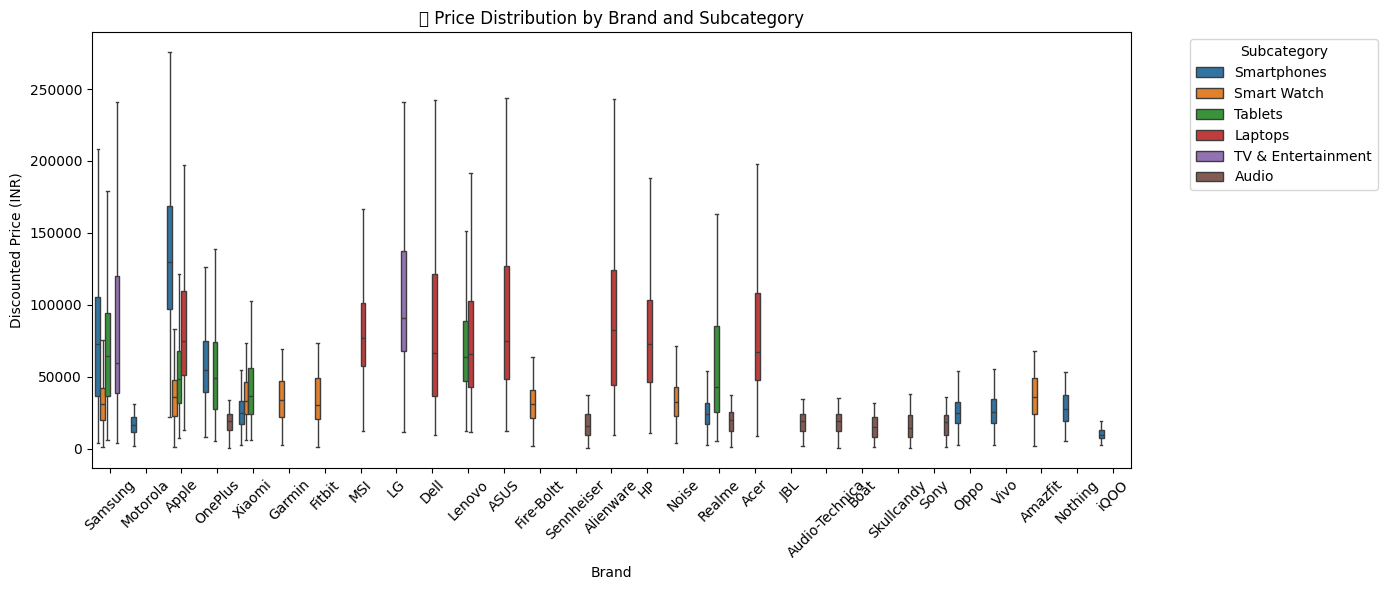

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\2094008663.py:50: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


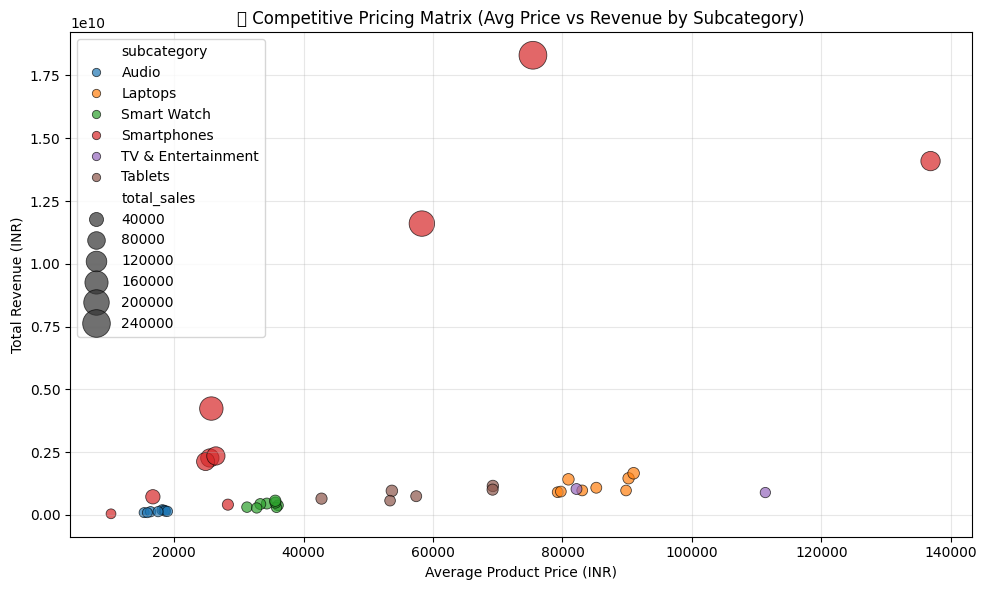

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\2094008663.py:63: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


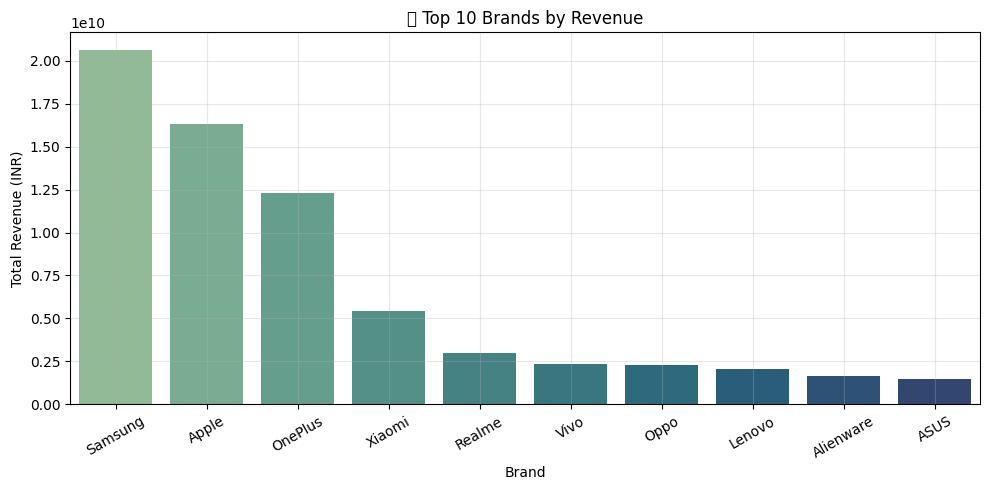

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\2094008663.py:79: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Temp\ipykernel_24300\2094008663.py:79: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


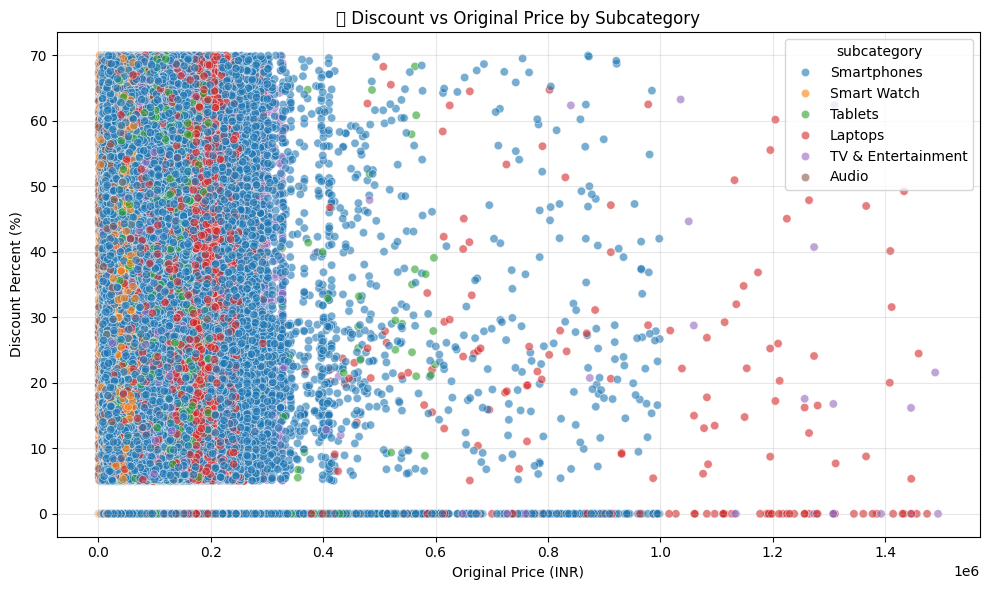

In [18]:
# =====================================
# 💰 COMPETITIVE PRICING & BRAND POSITIONING ANALYSIS
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure required columns exist ---
required_cols = ['brand', 'subcategory', 'final_amount_inr', 'original_price_inr', 'discounted_price_inr', 'quantity']
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing required columns:", required_cols)
else:

    # --- 1️⃣ Average Pricing and Revenue by Brand & Subcategory ---
    brand_pricing = df.groupby(['subcategory', 'brand']).agg(
        avg_price=('discounted_price_inr', 'mean'),
        avg_discount=('discount_percent', 'mean'),
        total_revenue=('final_amount_inr', 'sum'),
        total_sales=('quantity', 'sum')
    ).reset_index()

    # --- 2️⃣ Price Distribution by Brand (Box Plot) ---
    plt.figure(figsize=(14,6))
    sns.boxplot(data=df, x='brand', y='discounted_price_inr', hue='subcategory', showfliers=False)
    plt.title("🏷️ Price Distribution by Brand and Subcategory")
    plt.xlabel("Brand")
    plt.ylabel("Discounted Price (INR)")
    plt.legend(title="Subcategory", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ Competitive Pricing Matrix (Avg Price vs Revenue) ---
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=brand_pricing,
        x='avg_price',
        y='total_revenue',
        hue='subcategory',
        size='total_sales',
        sizes=(50, 400),
        alpha=0.7,
        edgecolor='black'
    )
    plt.title("💰 Competitive Pricing Matrix (Avg Price vs Revenue by Subcategory)")
    plt.xlabel("Average Product Price (INR)")
    plt.ylabel("Total Revenue (INR)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ Top 10 Brands by Revenue ---
    top_brands = brand_pricing.groupby('brand')['total_revenue'].sum().reset_index().sort_values(by='total_revenue', ascending=False).head(10)

    plt.figure(figsize=(10,5))
    sns.barplot(data=top_brands, x='brand', y='total_revenue', palette='crest')
    plt.title("🏆 Top 10 Brands by Revenue")
    plt.xlabel("Brand")
    plt.ylabel("Total Revenue (INR)")
    plt.xticks(rotation=30)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 5️⃣ Price vs Discount Correlation per Subcategory ---
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='original_price_inr',
        y='discount_percent',
        hue='subcategory',
        alpha=0.6
    )
    plt.title("🔍 Discount vs Original Price by Subcategory")
    plt.xlabel("Original Price (INR)")
    plt.ylabel("Discount Percent (%)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## 📊 Question 20: Business Health Dashboard

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\609946694.py:26: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


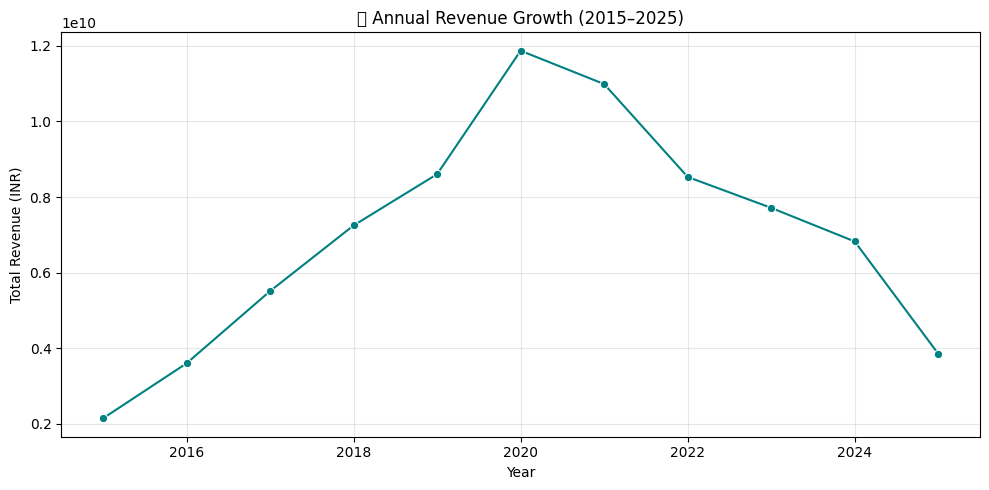

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\609946694.py:38: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


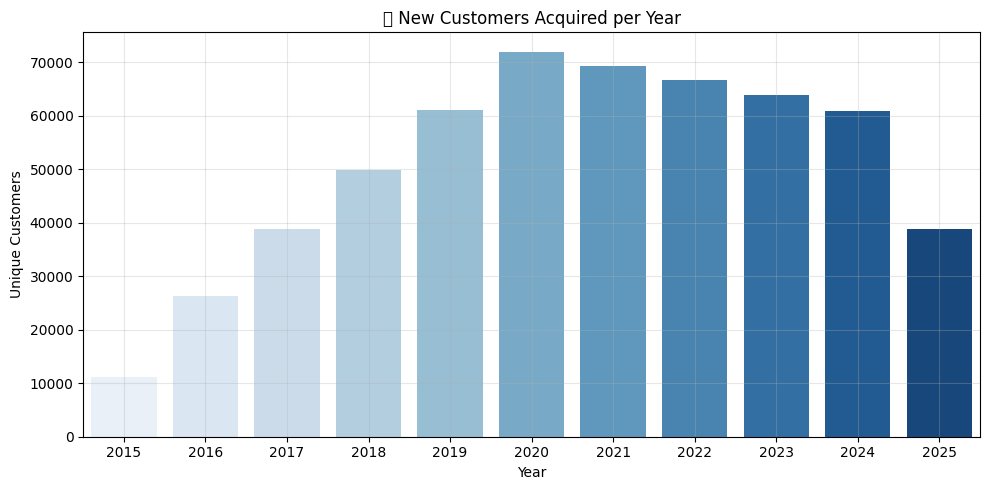

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\609946694.py:52: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


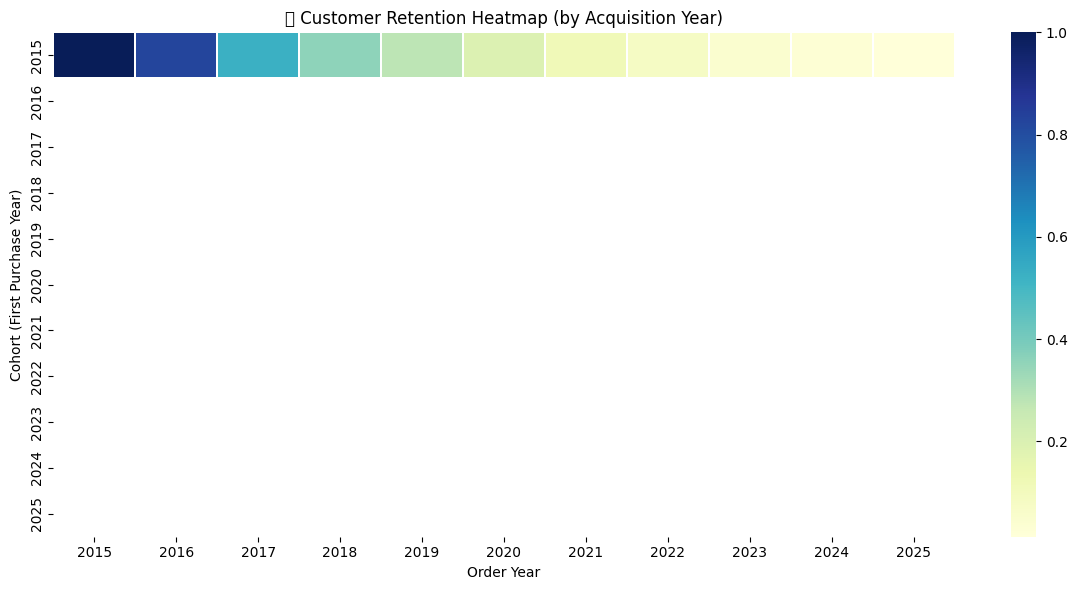

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\609946694.py:64: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


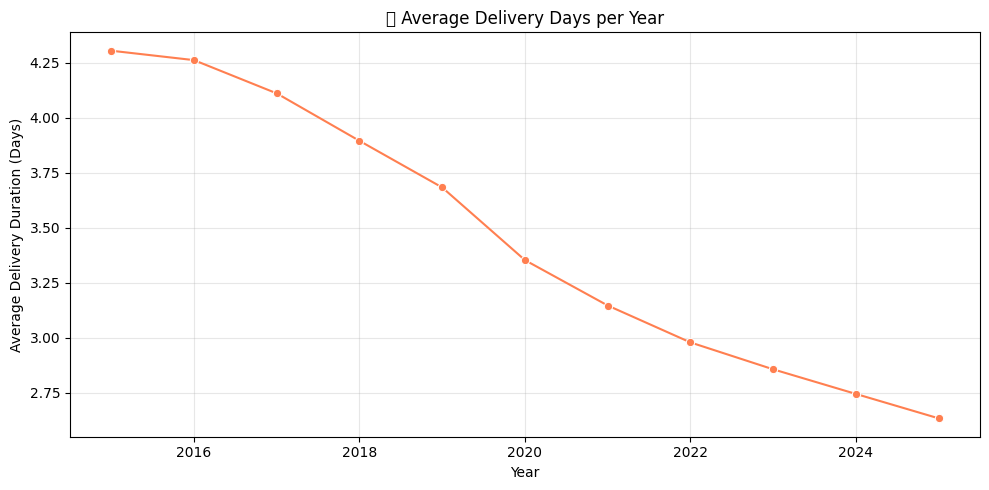

C:\Users\desik\AppData\Local\Temp\ipykernel_24300\609946694.py:77: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\desik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


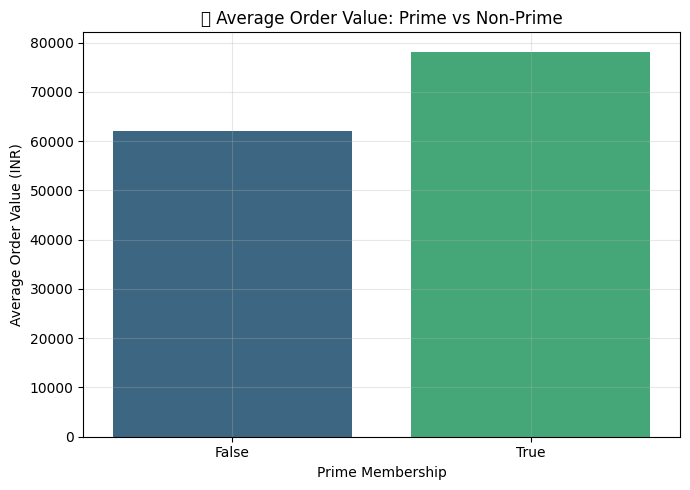

📊 EXECUTIVE SUMMARY INSIGHTS
----------------------------------------
✅ Total Revenue (2015–2025): ₹76,886,140,405
👥 Total Unique Customers: 354,968
📈 Customer Growth Rate (First vs Last Year): 245.98%
🚚 Avg Delivery Days (Recent Year): 2.63 days
⭐ Prime Share of Total Revenue: 43.65%


In [19]:
# =====================================
# 📊 BUSINESS HEALTH DASHBOARD (EXECUTIVE SUMMARY)
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure required columns exist ---
required_cols = [
    'order_year', 'customer_id', 'final_amount_inr',
    'transaction_id', 'delivery_days', 'is_prime_member'
]
if not all(col in df.columns for col in required_cols):
    print("⚠️ Missing required columns:", required_cols)
else:
    # --- 1️⃣ REVENUE TREND (2015–2025) ---
    revenue_trend = df.groupby('order_year')['final_amount_inr'].sum().reset_index()

    plt.figure(figsize=(10,5))
    sns.lineplot(data=revenue_trend, x='order_year', y='final_amount_inr', marker='o', color='teal')
    plt.title("💰 Annual Revenue Growth (2015–2025)")
    plt.xlabel("Year")
    plt.ylabel("Total Revenue (INR)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2️⃣ CUSTOMER ACQUISITION TREND ---
    customer_growth = df.groupby('order_year')['customer_id'].nunique().reset_index()

    plt.figure(figsize=(10,5))
    sns.barplot(data=customer_growth, x='order_year', y='customer_id', palette='Blues')
    plt.title("🧍 New Customers Acquired per Year")
    plt.xlabel("Year")
    plt.ylabel("Unique Customers")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 3️⃣ CUSTOMER RETENTION RATE (Cohort) ---
    df['first_order_year'] = df.groupby('customer_id')['order_year'].transform('min')
    cohort_retention = df.groupby(['first_order_year', 'order_year'])['customer_id'].nunique().reset_index()
    cohort_retention_pivot = cohort_retention.pivot(index='first_order_year', columns='order_year', values='customer_id')
    cohort_retention_rate = cohort_retention_pivot.divide(cohort_retention_pivot.iloc[:,0], axis=0)

    plt.figure(figsize=(12,6))
    sns.heatmap(cohort_retention_rate, cmap='YlGnBu', linewidths=0.3)
    plt.title("📈 Customer Retention Heatmap (by Acquisition Year)")
    plt.xlabel("Order Year")
    plt.ylabel("Cohort (First Purchase Year)")
    plt.tight_layout()
    plt.show()

    # --- 4️⃣ OPERATIONAL EFFICIENCY: DELIVERY PERFORMANCE ---
    delivery_perf = df.groupby('order_year')['delivery_days'].mean().reset_index()

    plt.figure(figsize=(10,5))
    sns.lineplot(data=delivery_perf, x='order_year', y='delivery_days', marker='o', color='coral')
    plt.title("🚚 Average Delivery Days per Year")
    plt.xlabel("Year")
    plt.ylabel("Average Delivery Duration (Days)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 5️⃣ PRIME vs NON-PRIME PERFORMANCE ---
    prime_perf = df.groupby('is_prime_member')['final_amount_inr'].agg(['mean', 'sum']).reset_index()
    prime_perf.columns = ['is_prime_member', 'avg_order_value', 'total_revenue']

    plt.figure(figsize=(7,5))
    sns.barplot(data=prime_perf, x='is_prime_member', y='avg_order_value', palette='viridis')
    plt.title("⭐ Average Order Value: Prime vs Non-Prime")
    plt.xlabel("Prime Membership")
    plt.ylabel("Average Order Value (INR)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 6️⃣ EXECUTIVE INSIGHTS SUMMARY ---
    print("📊 EXECUTIVE SUMMARY INSIGHTS")
    print("-" * 40)
    print(f"✅ Total Revenue (2015–2025): ₹{revenue_trend['final_amount_inr'].sum():,.0f}")
    print(f"👥 Total Unique Customers: {df['customer_id'].nunique():,}")
    print(f"📈 Customer Growth Rate (First vs Last Year): {round((customer_growth['customer_id'].iloc[-1] / customer_growth['customer_id'].iloc[0] - 1) * 100, 2)}%")
    print(f"🚚 Avg Delivery Days (Recent Year): {round(delivery_perf['delivery_days'].iloc[-1], 2)} days")
    print(f"⭐ Prime Share of Total Revenue: {round(prime_perf.loc[prime_perf['is_prime_member']==True, 'total_revenue'].sum() / revenue_trend['final_amount_inr'].sum() * 100, 2)}%")


In [20]:
df.columns

Index(['transaction_id', 'order_date', 'customer_id', 'product_id',
       'product_name', 'category', 'subcategory', 'brand',
       'original_price_inr', 'discount_percent', 'discounted_price_inr',
       'quantity', 'subtotal_inr', 'delivery_charges', 'final_amount_inr',
       'customer_city', 'customer_state', 'customer_tier',
       'customer_spending_tier', 'customer_age_group', 'payment_method',
       'delivery_days', 'delivery_type', 'is_prime_member', 'is_festival_sale',
       'festival_name', 'customer_rating', 'return_status', 'order_month',
       'order_year', 'order_quarter', 'product_weight_kg', 'is_prime_eligible',
       'product_rating', 'dup_key', 'dup_count', 'dup_status',
       'flag_for_review', 'order_month_name', 'order_ym', 'first_order_year',
       'cohort_month', 'order_month_dt', 'launch_year'],
      dtype='object')